# Modeling COVID-19 Pandemic in New York State with Epydemix

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on weekly deaths during the first wave in New York State, US. 

Let's import needed packages:

In [99]:
import numpy as np 
import os
import pandas as pd 
from epydemix.calibration.calibration_results import CalibrationResults
from epydemix.calibration.metrics import *
from datetime import datetime, timedelta
from epydemix.utils.abc_smc_utils import DefaultPerturbationContinuous, DefaultPerturbationDiscrete, sample_prior
from epydemix.utils.utils import combine_simulation_outputs
from typing import Callable, Dict, Any, Optional, Tuple

def wrapper_function(func, *args, **kwargs):
    """
    Wrapper function to ensure the passed function returns a dictionary.
    
    Parameters:
    - func: The function to be called.
    - *args, **kwargs: Arguments and keyword arguments for the function.

    Returns:
    - The output of the passed function if it's a dictionary.

    Raises:
    - ValueError: If the function does not return a dictionary.
    """
    result = func(*args, **kwargs)
    if not isinstance(result, dict):
        raise ValueError(f"The function {func.__name__} must return a dictionary, but it returned {type(result)}.")
    return result


def calibrate(strategy: str, 
              simulation_function: Callable[[Dict[str, Any]], Any], 
              priors: Dict[str, Any], 
              parameters: Dict[str, Any], 
              observed_data: Dict[str, Any], 
              top_fraction: float = 0.05, 
              Nsim : int = 100, 
              epsilon: float = 0.1,
              num_particles: int = 1000, 
              distance_function: Callable[[Dict[str, Any], Any], float] = rmse, 
              max_generations: int = 10, 
              epsilon_quantile_level: float = 0.50,
              minimum_epsilon: float = 0.15, 
              max_time: Optional[timedelta] = None,   
              total_simulations_budget: Optional[int] = None,             
              epsilon_schedule = None, 
              perturbations = None) -> CalibrationResults:
    """
    Unified calibration function to handle top fraction, ABC rejection, and ABC SMC methods.
    
    Args:
        strategy (str): The calibration strategy to use ("abc_top_fraction", "abc_rejection", or "abc_smc").
        simulation_function (Callable[[Dict[str, Any]], Any]): The function that runs the simulation, which takes the parameters dictionary as input.
        priors (Dict[str, Any]): A dictionary of prior distributions for the parameters.
        parameters (Dict[str, Any]): A dictionary of parameters used in the simulation.
        observed_data (Dict[str, Any]): A dictionary containing the observed data. Key must be "data".
        top_fraction (float, optional): Top fraction of simulations to select based on error metric (used in "abc_top_fraction").
        Nsim (int, optional): The number of simulation runs to perform in "abc_top_fraction" approach (default is 100).
        epsilon (float, optional): Error tolerance for rejection sampling (used in "abc_rejection").
        num_particles (int, optional): Number of particles for "abc_rejection" and "abc_smc" approach (default is 1000).
        distance_function (Callable[[Dict[str, Any], Any], float], optional): The error metric function used to evaluate the simulations (default is rmse).
        max_generations (int, optional): Maximum number of generations for ABC SMC (used in "abc_smc" approach).
        epsilon_quantile_level (float, optional): Quantile level to set next generation's epsilon (used in "abc_smc" approach).
        minimum_epsilon (float, optional): Minimum tolerance for ABC SMC (used in "abc_smc" approach).
        max_time (Optional[timedelta], optional): Maximum time allowed for ABC SMC calibration (used in "abc_smc" approach).
        total_simulations_budget (Optional[int], optional): Maximum number of simulations allowed for ABC SMC calibration (used in "abc_smc" approach).
        epsilon_schedule (Optional[List[float]], optional): List of epsilon thresholds for each generation (used in "abc_smc" approach).
        perturbations (Optional[Dict[str, Any]], optional): Dictionary of parameter_name -> Perturbation objects (used in "abc_smc" approach).
        
    Returns:
        CalibrationResults: The results of the calibration, including posterior distributions and selected simulations.
    """
    
    if strategy == "abc_top_fraction":
        return calibration_abc_top_fraction(simulation_function=simulation_function, 
                                    priors=priors, 
                                    parameters=parameters, 
                                    observed_data=observed_data, 
                                    top_fraction=top_fraction, 
                                    distance_function=distance_function, 
                                    Nsim=Nsim)
    
    elif strategy == "abc_rejection":
        return calibration_abc_rejection(simulation_function, 
                                         priors, 
                                         parameters, 
                                         observed_data, 
                                         epsilon=epsilon, 
                                         distance_function=distance_function, 
                                         num_particles=num_particles, 
                                         max_time=max_time,
                                         total_simulations_budget=total_simulations_budget)
    
    elif strategy == "abc_smc":
        return calibration_abc_smc(observed_data=observed_data, 
                                    num_particles=num_particles, 
                                    num_generations=max_generations, 
                                    epsilon_schedule=epsilon_schedule, 
                                    priors=priors, 
                                    epsilon_quantile_level=epsilon_quantile_level, 
                                    perturbations=perturbations, 
                                    distance_function=distance_function,
                                    simulate_model=simulation_function, 
                                    user_params=parameters, 
                                    minimum_epsilon=minimum_epsilon, 
                                    max_time=max_time, 
                                    total_simulations_budget=total_simulations_budget)
                            
    else:
        raise ValueError(f"Unsupported calibration strategy: {strategy}")


def calibration_abc_top_fraction(simulation_function: Callable, 
                                 priors: Dict[str, Any], 
                                 parameters: Dict[str, Any], 
                                 observed_data: Dict[str, Any],
                                 top_fraction: float = 0.05,
                                 distance_function: Callable[[Dict[str, Any], Any], float] = rmse,
                                 Nsim: int = 100) -> CalibrationResults:
    """
    Calibrates the model by selecting the top percentage of simulations based on the chosen error metric.

    Args:
        simulation_function (Callable[[Dict[str, Any]], Any]): The function that runs the simulation, taking a dictionary of parameters as input.
        priors (Dict[str, Any]): A dictionary of prior distributions for the parameters.
        parameters (Dict[str, Any]): A dictionary of parameters used in the simulation.
        observed_data (Dict[str, Any]): A dictionary containing the observed data with a key "data" pointing to observations.
        top_fraction (float, optional): The top fraction of simulations to select based on the error metric (default is 0.05).
        distance_function (Callable[[Dict[str, Any], Any], float], optional): The error metric function used to evaluate the simulations (default is rmse).
        Nsim (int, optional): The number of simulation runs to perform (default is 100).

    Returns:
        CalibrationResults: An object containing the results of the calibration, including the posterior distribution, selected trajectories, and quantiles.
    """
    
    simulations, distances = [], []
    sampled_params = {p: [] for p in priors.keys()}

    # Parameter names for consistent indexing
    param_names = list(priors.keys())

    # Run simulations
    for _ in range(Nsim):
        params = sample_prior(priors, param_names)
        full_params = {**parameters, **dict(zip(param_names, params))}
        results = wrapper_function(simulation_function, full_params)
        distance = distance_function(data=observed_data, simulation=results)
        simulations.append(results)
        distances.append(distance)
        for i, p in enumerate(param_names):
            sampled_params[p].append(params[i])

    # Compute distance threshold
    distance_threshold = np.quantile(distances, q=top_fraction)
    idxs = np.argwhere(np.array(distances) <= distance_threshold).ravel()

    # select runs and parameters
    selected_simulations = np.array(simulations)[idxs]
    selected_params = {p: np.array(arr)[idxs] for p, arr in sampled_params.items()}

    # format results 
    results = CalibrationResults(
        calibration_strategy="abc_top_fraction",
        posterior_distributions={0: pd.DataFrame(data=selected_params)},
        selected_trajectories={0: selected_simulations},
        distances={0: np.array(distances)[idxs]},
        observed_data=observed_data,
        priors=priors,
        calibration_params={
            "top_fraction": top_fraction, 
            "distance_function": distance_function, 
            "Nsim": Nsim
        }
    )
    return results


def calibration_abc_smc_working(observed_data, 
            num_particles, 
            num_generations, 
            epsilon_schedule=None, 
            priors=None, 
            epsilon_quantile_level=0.5, 
            perturbations=None, 
            distance_function=rmse,
            simulate_model=None, 
            user_params=None, 
            minimum_epsilon=None, 
            max_time=None, 
            total_simulations_budget=None):
    """
    Implements the ABC-SMC algorithm with a customizable simulation model.

    Args:
        observed_data: the observed dataset
        num_particles: number of particles in each generation
        num_generations: number of generations to run
        epsilon_schedule: list of epsilon thresholds for each generation (optional)
        priors: dictionary of parameter_name -> scipy.stats prior distribution
        epsilon_quantile_level: quantile level to set next generation's epsilon (default 0.5)
        perturbations: dictionary of parameter_name -> Perturbation objects (optional)
        distance_function: function that computes the distance between observed and simulated data
        simulate_model: function that simulates data given a dictionary of parameters
        user_params: dictionary of fixed parameters provided by the user (optional)
        minimum_epsilon: minimum epsilon threshold (optional)
        max_time: maximum time allowed for calibration (optional)
        total_simulations_budget: maximum number of simulations allowed for calibration (optional)
    
    Returns: 
        CalibrationResults: An object containing the results of the calibration, including the posterior distribution, selected trajectories, and quantiles.
    """
    if simulate_model is None:
        raise ValueError("A simulation model function must be provided.")
    
    if user_params is None:
        user_params = {}

    # Define the results object 
    results = CalibrationResults(calibration_strategy="abc_smc") 

    particles, weights, distances, simulations = [], [], [], []

    # Parameter names for consistent indexing
    param_names = list(priors.keys())

    # Separate parameters into continuous and discrete
    continuous_params = [name for name in param_names if hasattr(priors[name], 'pdf')]
    discrete_params = [name for name in param_names if name not in continuous_params]

    # Choose perturbation functions
    if perturbations is None:
        perturbations = {
            param: (DefaultPerturbationContinuous(param) if param in continuous_params else DefaultPerturbationDiscrete(param, priors[param]))
            for param in param_names
        }
    else: 
        for param in param_names:
            if param not in perturbations.keys():
                if param in continuous_params:
                    perturbations[param] = DefaultPerturbationContinuous(param)
                else:
                    perturbations[param] = DefaultPerturbationDiscrete(param, priors[param])

    # Initialize the first generation 
    for _ in range(num_particles):
        params = sample_prior(priors, param_names)
        full_params = {**user_params, **dict(zip(param_names, params))}
        simulated_data = wrapper_function(simulate_model, full_params)
        dist = distance_function(data=observed_data, simulation=simulated_data)
        particles.append(params)
        weights.append(1.0 / num_particles)
        distances.append(dist)
        simulations.append(simulated_data)

    particles = np.array(particles)
    weights = np.array(weights)
    distances = np.array(distances)
    simulations = np.array(simulations)

    # Set the results for the first generation
    results.posterior_distributions[0] = pd.DataFrame(data={param_names[i]: particles[:, i] for i in range(len(param_names))})
    results.distances[0] = distances
    results.weights[0] = weights
    results.selected_trajectories[0] = simulations

    # Sequential generations
    start_time = datetime.now()
    n_simulations = 0 # Counter for total number of simulations
    for gen in range(0, num_generations):
        start_generation_time = datetime.now()

        # Compute epsilon for the generation
        if epsilon_schedule is None:
            epsilon = np.quantile(distances, epsilon_quantile_level)
        else:
            epsilon = epsilon_schedule[gen]

        print(f"Running generation {gen + 1}, epsilon: {epsilon}")

        # Check if minimum tolerance is reached
        if minimum_epsilon is not None and epsilon < minimum_epsilon:
            print(f"Minimum epsilon reached at generation {gen + 1}")
            break

        # Check if the walltime has been reached
        if max_time is not None and datetime.now() - start_time > max_time:
            print(f"Maximum time reached at generation {gen + 1}")
            break

        # Check if the total simulations budget has been reached
        if total_simulations_budget is not None and n_simulations > total_simulations_budget:
            print(f"Total simulations budget reached at generation {gen + 1}")
            break

        # Update perturbations based on particles and weights
        for perturbation in perturbations.values():
            perturbation.update(particles, weights, param_names)

        new_particles, new_weights, new_distances, new_simulations = [], [], [], []
        for _ in range(num_particles):
            while True:
                # Resample a particle based on weights
                index = np.random.choice(len(particles), p=weights / weights.sum())
                candidate_params = particles[index]

                # reconstruct candidate params from particles and weights
                # first, continuous params are sampled independently from particles based on the weights
                # then, discrete params are sampled from the particles based on their frequency in the particles
                #candidate_params = []
                #for i, param in enumerate(param_names):
                #    if param in continuous_params:
                #        candidate_params.append(particles[np.random.choice(len(particles), p=weights / weights.sum())][i])
                #    else:
                #        # sample discrete params from particles based on their frequency in the particles
                #        discrete_values = np.unique(particles[:, i])
                #        # get the frequency of each discrete value
                #        discrete_frequencies = [np.sum(particles[:, i] == value) / len(particles) for value in discrete_values]
                #        # sample the discrete value based on the frequency
                #        candidate_params.append(np.random.choice(discrete_values, p=discrete_frequencies))

                # Propose new parameters (perturbation kernel)
                perturbed_params = [
                    perturbations[param_names[i]].propose(candidate_params[i]) for i in range(len(param_names))
                ]
                full_params = {**user_params, **dict(zip(param_names, perturbed_params))}

                # Check if perturbed parameters have prior probability > 0
                prior_probabilities = [
                  priors[param].pdf(perturbed_params[i]) if param in continuous_params
                  else priors[param].pmf(perturbed_params[i])
                  for i, param in enumerate(param_names)
                ]
                if all(prob > 0 for prob in prior_probabilities):
                    simulated_data = wrapper_function(simulate_model, full_params)
                    dist = distance_function(data=observed_data, simulation=simulated_data)
                    n_simulations += 1

                    if dist < epsilon:
                        new_particles.append(perturbed_params)
                        weight_numerator = np.prod([
                          priors[param].pdf(perturbed_params[i]) if param in continuous_params
                          else priors[param].pmf(perturbed_params[i])
                          for i, param in enumerate(param_names)
                        ])
                        weight_denominator = np.sum([
                            weights[j] * np.prod([
                                perturbations[param_names[i]].pdf(
                                    perturbed_params[i], particles[j][i]
                                ) for i in range(len(param_names))
                            ]) for j in range(len(particles))
                        ])
                        new_weights.append(weight_numerator / weight_denominator)
                        new_distances.append(dist)
                        new_simulations.append(simulated_data)
                        break

        # Normalize weights
        new_weights = np.array(new_weights)
        new_weights /= new_weights.sum()

        particles = np.array(new_particles)
        weights = new_weights
        distances = np.array(new_distances)
        simulations = np.array(new_simulations)

        # Set the results for the generation
        results.posterior_distributions[gen + 1] = pd.DataFrame(data={param_names[i]: particles[:, i] for i in range(len(param_names))})
        results.distances[gen + 1] = distances
        results.weights[gen + 1] = weights
        results.selected_trajectories[gen + 1] = simulations

        # Print generation information
        end_generation_time = datetime.now()
        elapsed_time = end_generation_time - start_generation_time
        formatted_time = f"{elapsed_time.seconds // 3600:02}:{(elapsed_time.seconds % 3600) // 60:02}:{elapsed_time.seconds % 60:02}"
        print(f"\tElapsed time: {formatted_time}") 

    # Complete the results object
    results.observed_data = observed_data
    results.priors = priors
    results.calibration_params = {
        "num_particles": num_particles,
        "minimum_epsilon": minimum_epsilon,
        "distance_function": distance_function,
        "num_generations": num_generations,
        "max_time": max_time, 
        "total_simulations_budget": total_simulations_budget, 
        "epsilon_schedule": epsilon_schedule,
        "perturbations": perturbations
    }

    return results


def calibration_abc_rejection(simulation_function: Callable, 
                              priors: Dict[str, Any], 
                              parameters: Dict[str, Any], 
                              observed_data: Dict[str, Any],
                              epsilon: float,
                              distance_function: Callable[[Dict[str, Any], Any], float] = rmse,
                              num_particles: int = 100, 
                              max_time=None, 
                              total_simulations_budget=None) -> CalibrationResults:
    """
    Calibrates the model using Approximate Bayesian Computation (ABC) rejection sampling.

    Args:
        simulation_function (Callable): The function that runs the simulation, taking a dictionary of parameters as input.
        priors (Dict[str, Any]): A dictionary of prior distributions for the parameters.
        parameters (Dict[str, Any]): A dictionary of model parameters.
        observed_data (Dict[str, Any]): The observed data.
        epsilon (float): The error tolerance for accepting a simulation.
        distance_function (Callable[[Dict[str, Any], Any], float], optional): The error metric function used to evaluate the simulations (default is rmse).
        num_particles (int, optional): The number of particles to accept based on the tolerance (default is 100).
        max_time: maximum time allowed for calibration (optional)
        total_simulations_budget: maximum number of simulations allowed for calibration (optional)

    Returns:
        CalibrationResults: An object containing the results of the calibration, including the posterior distribution, selected trajectories, and quantiles.
    """

    simulations, distances = [], []
    sampled_params = {p: [] for p in priors.keys()}

    # Parameter names for consistent indexing
    param_names = list(priors.keys())

    start_time = datetime.now()
    n_simulations = 0 # Counter for total number of simulations
    while len(distances) < num_particles: 
        params = sample_prior(priors, param_names)
        full_params = {**parameters, **dict(zip(param_names, params))}
        results = wrapper_function(simulation_function, full_params)
        distance = distance_function(data=observed_data, simulation=results)
        if distance < epsilon:
            simulations.append(results)
            distances.append(distance)
            for i, p in enumerate(param_names):
                sampled_params[p].append(params[i])

        n_simulations += 1

        # Check if the walltime has been reached
        if max_time is not None and datetime.now() - start_time > max_time:
            print(f"Maximum time reached")
            break

        # Check if the total simulations budget has been reached
        if total_simulations_budget is not None and n_simulations > total_simulations_budget:
            print(f"Total simulations budget reached")
            break

    # format results 
    results = CalibrationResults(
        calibration_strategy="abc_rejection",
        posterior_distributions={0: pd.DataFrame(data=sampled_params)},
        selected_trajectories={0: simulations},
        distances={0: np.array(distances)},
        observed_data=observed_data,
        priors=priors,
        calibration_params={
            "epsilon": epsilon,
            "distance_function": distance_function, 
            "num_particles": num_particles, 
            "max_time": max_time,
            "total_simulations_budget": total_simulations_budget
        }
    )
    
    return results


def run_projections(simulation_function: Callable, 
                    calibration_results: CalibrationResults, 
                    parameters: Dict[str, Any],
                    iterations: int = 100) -> Tuple[Dict[str, Any], pd.DataFrame]: 
    """
    Runs projections based on the posterior distribution obtained from calibration.

    Args:
        simulation_function (Callable[[Dict[str, Any]], Any]): The function that runs the simulation, taking a dictionary of parameters as input.
        calibration_results (CalibrationResults): The results from a calibration process, containing the posterior distribution.
        parameters (Dict[str, Any]): A dictionary of parameters used for the projections.
        iterations (int, optional): The number of projection iterations to run (default is 100).

    Returns:
        Tuple[Dict[str, Any], pd.DataFrame]: A dictionary containing the formatted projections and a DataFrame containing the posterior samples used for each iteration.
    """
        
    # get posterior distribution
    posterior_distribution = calibration_results.get_posterior_distribution()
    
    # run projections and store results
    projections, posterior_samples = [], {}
    for n in range(iterations): 
        # sample from posterior
        posterior_sample = posterior_distribution.iloc[np.random.randint(0, len(posterior_distribution))]

        for k in posterior_sample.keys():
            if k not in posterior_samples.keys():
                posterior_samples[k] = []
            posterior_samples[k].append(posterior_sample[k])
        
        # prepare and run simulation
        parameters.update(posterior_sample)
        result_projections = simulation_function(parameters)
        projections.append(result_projections)

    # combine results
    projections_formatted = combine_simulation_outputs(projections)

    return projections_formatted, pd.DataFrame(posterior_samples)



def calibration_abc_smc(observed_data, 
            num_particles, 
            num_generations, 
            epsilon_schedule=None, 
            priors=None, 
            epsilon_quantile_level=0.5, 
            perturbations=None, 
            distance_function=rmse,
            simulate_model=None, 
            user_params=None, 
            minimum_epsilon=None, 
            max_time=None, 
            total_simulations_budget=None):
    """
    Implements the ABC-SMC algorithm with a customizable simulation model.

    Args:
        observed_data: the observed dataset
        num_particles: number of particles in each generation
        num_generations: number of generations to run
        epsilon_schedule: list of epsilon thresholds for each generation (optional)
        priors: dictionary of parameter_name -> scipy.stats prior distribution
        epsilon_quantile_level: quantile level to set next generation's epsilon (default 0.5)
        perturbations: dictionary of parameter_name -> Perturbation objects (optional)
        distance_function: function that computes the distance between observed and simulated data
        simulate_model: function that simulates data given a dictionary of parameters
        user_params: dictionary of fixed parameters provided by the user (optional)
        minimum_epsilon: minimum epsilon threshold (optional)
        max_time: maximum time allowed for calibration (optional)
        total_simulations_budget: maximum number of simulations allowed for calibration (optional)
    
    Returns: 
        CalibrationResults: An object containing the results of the calibration, including the posterior distribution, selected trajectories, and quantiles.
    """
    if simulate_model is None:
        raise ValueError("A simulation model function must be provided.")
    
    if user_params is None:
        user_params = {}

    # Define the results object 
    results = CalibrationResults(calibration_strategy="abc_smc") 

    particles, weights, distances, simulations = [], [], [], []

    # Parameter names for consistent indexing
    param_names = list(priors.keys())

    # Separate parameters into continuous and discrete
    continuous_params = [name for name in param_names if hasattr(priors[name], 'pdf')]
    discrete_params = [name for name in param_names if name not in continuous_params]

    # Choose perturbation functions
    if perturbations is None:
        perturbations = {
            param: (DefaultPerturbationContinuous(param) if param in continuous_params else DefaultPerturbationDiscrete(param, priors[param]))
            for param in param_names
        }
    else: 
        for param in param_names:
            if param not in perturbations.keys():
                if param in continuous_params:
                    perturbations[param] = DefaultPerturbationContinuous(param)
                else:
                    perturbations[param] = DefaultPerturbationDiscrete(param, priors[param])

    # Initialize the first generation 
    for _ in range(num_particles):
        params = sample_prior(priors, param_names)
        full_params = {**user_params, **dict(zip(param_names, params))}
        simulated_data = wrapper_function(simulate_model, full_params)
        dist = distance_function(data=observed_data, simulation=simulated_data)
        particles.append(params)
        weights.append(1.0 / num_particles)
        distances.append(dist)
        simulations.append(simulated_data)

    particles = np.array(particles)
    weights = np.array(weights)
    distances = np.array(distances)
    simulations = np.array(simulations)

    # Set the results for the first generation
    results.posterior_distributions[0] = pd.DataFrame(data={param_names[i]: particles[:, i] for i in range(len(param_names))})
    results.distances[0] = distances
    results.weights[0] = weights
    results.selected_trajectories[0] = simulations

    # Sequential generations
    start_time = datetime.now()
    n_simulations = 0 # Counter for total number of simulations
    for gen in range(0, num_generations):
        start_generation_time = datetime.now()

        # Compute epsilon for the generation
        if epsilon_schedule is None:
            epsilon = np.quantile(distances, epsilon_quantile_level)
        else:
            epsilon = epsilon_schedule[gen]

        print(f"Running generation {gen + 1}, epsilon: {epsilon}")

        # Check if minimum tolerance is reached
        if minimum_epsilon is not None and epsilon < minimum_epsilon:
            print(f"Minimum epsilon reached at generation {gen + 1}")
            break

        # Check if the walltime has been reached
        if max_time is not None and datetime.now() - start_time > max_time:
            print(f"Maximum time reached at generation {gen + 1}")
            break

        # Check if the total simulations budget has been reached
        if total_simulations_budget is not None and n_simulations > total_simulations_budget:
            print(f"Total simulations budget reached at generation {gen + 1}")
            break

        # Update perturbations based on particles and weights
        for perturbation in perturbations.values():
            perturbation.update(particles, weights, param_names)

        new_particles, new_weights, new_distances, new_simulations = [], [], [], []

        # compute weights for discrete params
        discrete_weights = np.zeros((len(particles), len(param_names)))
        for i, param in enumerate(param_names):
            if param in discrete_params:
                for j in range(len(particles)):
                    discrete_weights[j, i] = np.sum(particles[:, i] == particles[j, i]) / len(particles)

        for _ in range(num_particles):
            while True:
                # Resample a particle based on weights
                #index = np.random.choice(len(particles), p=weights / weights.sum())
                #candidate_params = particles[index]

                # reconstruct candidate params from particles and weights
                # first, continuous params are sampled independently from particles based on the weights
                # then, discrete params are sampled from the particles based on their frequency in the particles
                candidate_params = []
                for i, param in enumerate(param_names):
                    if param in continuous_params:
                        candidate_params.append(particles[np.random.choice(len(particles), p=weights / weights.sum())][i])
                    else:
                        # sample discrete params from particles based on their frequency in the particles
                        discrete_values = np.unique(particles[:, i])
                        # get the frequency of each discrete value
                        discrete_frequencies = [np.sum(particles[:, i] == value) / len(particles) for value in discrete_values]
                        # sample the discrete value based on the frequency
                        candidate_params.append(np.random.choice(discrete_values, p=discrete_frequencies))

                # Propose new parameters (perturbation kernel)
                perturbed_params = [
                    perturbations[param_names[i]].propose(candidate_params[i]) for i in range(len(param_names))
                ]
                full_params = {**user_params, **dict(zip(param_names, perturbed_params))}

                # Check if perturbed parameters have prior probability > 0
                prior_probabilities = [
                  priors[param].pdf(perturbed_params[i]) if param in continuous_params
                  else priors[param].pmf(perturbed_params[i])
                  for i, param in enumerate(param_names)
                ]
                if all(prob > 0 for prob in prior_probabilities):
                    simulated_data = wrapper_function(simulate_model, full_params)
                    dist = distance_function(data=observed_data, simulation=simulated_data)
                    n_simulations += 1

                    if dist < epsilon:
                        new_particles.append(perturbed_params)
                        weight_numerator = np.prod([
                          priors[param].pdf(perturbed_params[i]) if param in continuous_params
                          else priors[param].pmf(perturbed_params[i])
                          for i, param in enumerate(param_names)
                        ])

                        weight_denominator = 0
                        for j in range(len(particles)):
                            pdfs = []
                            for i, param in enumerate(param_names):
                                if param in continuous_params:
                                    el = weights[j] * perturbations[param].pdf(perturbed_params[i], particles[j][i])
                                else:
                                    el = discrete_weights[j][i] * perturbations[param].pdf(perturbed_params[i], particles[j][i])
                                pdfs.append(el)
                            weight_denominator += np.prod(pdfs)
                            
                        new_weights.append(weight_numerator / weight_denominator)
                        new_distances.append(dist)
                        new_simulations.append(simulated_data)
                        break

        # Normalize weights
        new_weights = np.array(new_weights)
        new_weights /= new_weights.sum()

        particles = np.array(new_particles)
        weights = new_weights
        distances = np.array(new_distances)
        simulations = np.array(new_simulations)

        # Set the results for the generation
        results.posterior_distributions[gen + 1] = pd.DataFrame(data={param_names[i]: particles[:, i] for i in range(len(param_names))})
        results.distances[gen + 1] = distances
        results.weights[gen + 1] = weights
        results.selected_trajectories[gen + 1] = simulations

        # Print generation information
        end_generation_time = datetime.now()
        elapsed_time = end_generation_time - start_generation_time
        formatted_time = f"{elapsed_time.seconds // 3600:02}:{(elapsed_time.seconds % 3600) // 60:02}:{elapsed_time.seconds % 60:02}"
        print(f"\tElapsed time: {formatted_time}") 

    # Complete the results object
    results.observed_data = observed_data
    results.priors = priors
    results.calibration_params = {
        "num_particles": num_particles,
        "minimum_epsilon": minimum_epsilon,
        "distance_function": distance_function,
        "num_generations": num_generations,
        "max_time": max_time, 
        "total_simulations_budget": total_simulations_budget, 
        "epsilon_schedule": epsilon_schedule,
        "perturbations": perturbations
    }

    return results

In [37]:
# Initialize the first generation 
num_particles = 100
particles, weights, distances, simulations = [], [], [], []
param_names = list(priors.keys())
for _ in range(num_particles):
    params = sample_prior(priors, param_names)
    full_params = {**parameters, **dict(zip(param_names, params))}
    simulated_data = wrapper_function(simulate_wrapper, full_params)
    dist = wmape(data={"data":  epi_data["data"].values}, simulation=simulated_data)
    particles.append(params)
    weights.append(1.0 / num_particles)
    distances.append(dist)
    simulations.append(simulated_data)

In [45]:
# Separate parameters into continuous and discrete
continuous_params = [name for name in param_names if hasattr(priors[name], 'pdf')]
discrete_params = [name for name in param_names if name not in continuous_params]

particles = np.array(particles)
weights = np.array(weights)
# compute weights for discrete params
discrete_weights = np.zeros((len(particles), len(param_names)))
for i, param in enumerate(param_names):
    if param in discrete_params:
        for j in range(len(particles)):
            discrete_weights[j, i] = np.sum(particles[:, i] == particles[j, i]) / len(particles)

In [46]:
candidate_params = []
for i, param in enumerate(param_names):
    if param in continuous_params:
        candidate_params.append(particles[np.random.choice(len(particles), p=weights / weights.sum())][i])
    else:
        # sample discrete params from particles based on their frequency in the particles
        discrete_values = np.unique(particles[:, i])
        # get the frequency of each discrete value
        discrete_frequencies = [np.sum(particles[:, i] == value) / len(particles) for value in discrete_values]
        # sample the discrete value based on the frequency
        candidate_params.append(np.random.choice(discrete_values, p=discrete_frequencies))


In [76]:
perturbations = {
            param: (DefaultPerturbationContinuous(param) if param in continuous_params else DefaultPerturbationDiscrete(param, priors[param]))
            for param in param_names
        }
perturbed_params = [
                    perturbations[param_names[i]].propose(candidate_params[i]) for i in range(len(param_names))
                ]

perturbed_params

[2.0626129025211877, 24.0, 6479.0, 0.9287209509759148, 0.5582208216087194]

In [98]:
weight_numerator = np.prod([
                          priors[param].pdf(perturbed_params[i]) if param in continuous_params
                          else priors[param].pmf(perturbed_params[i])
                          for i, param in enumerate(param_names)
                        ])
                        
weight_denominator = 0
for j in range(len(particles)):
    pdfs = []
    for i, param in enumerate(param_names):
        if param in continuous_params:
            el = weights[j] * perturbations[param].pdf(perturbed_params[i], particles[j][i])
        else:
            el = discrete_weights[j][i] * perturbations[param].pdf(perturbed_params[i], particles[j][i])
        pdfs.append(el)
    weight_denominator += np.prod(pdfs)

weight_denominator

1.9034229516168582e-14

In [95]:
perturbations["R0"].pdf(2.0626129025211877, 5.94444432721979)

0.0

In [89]:
discrete_weights[:, 3].min()

0.0

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
#from epydemix.calibration import calibrate
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
from epydemix.calibration.metrics import wmape
import numpy as np 
from datetime import datetime
from scipy import stats 

Second, we import and plot the epidemic data on weekly deaths that we want to model:

<Axes: title={'center': 'New York State'}, xlabel='date', ylabel='weekly deaths'>

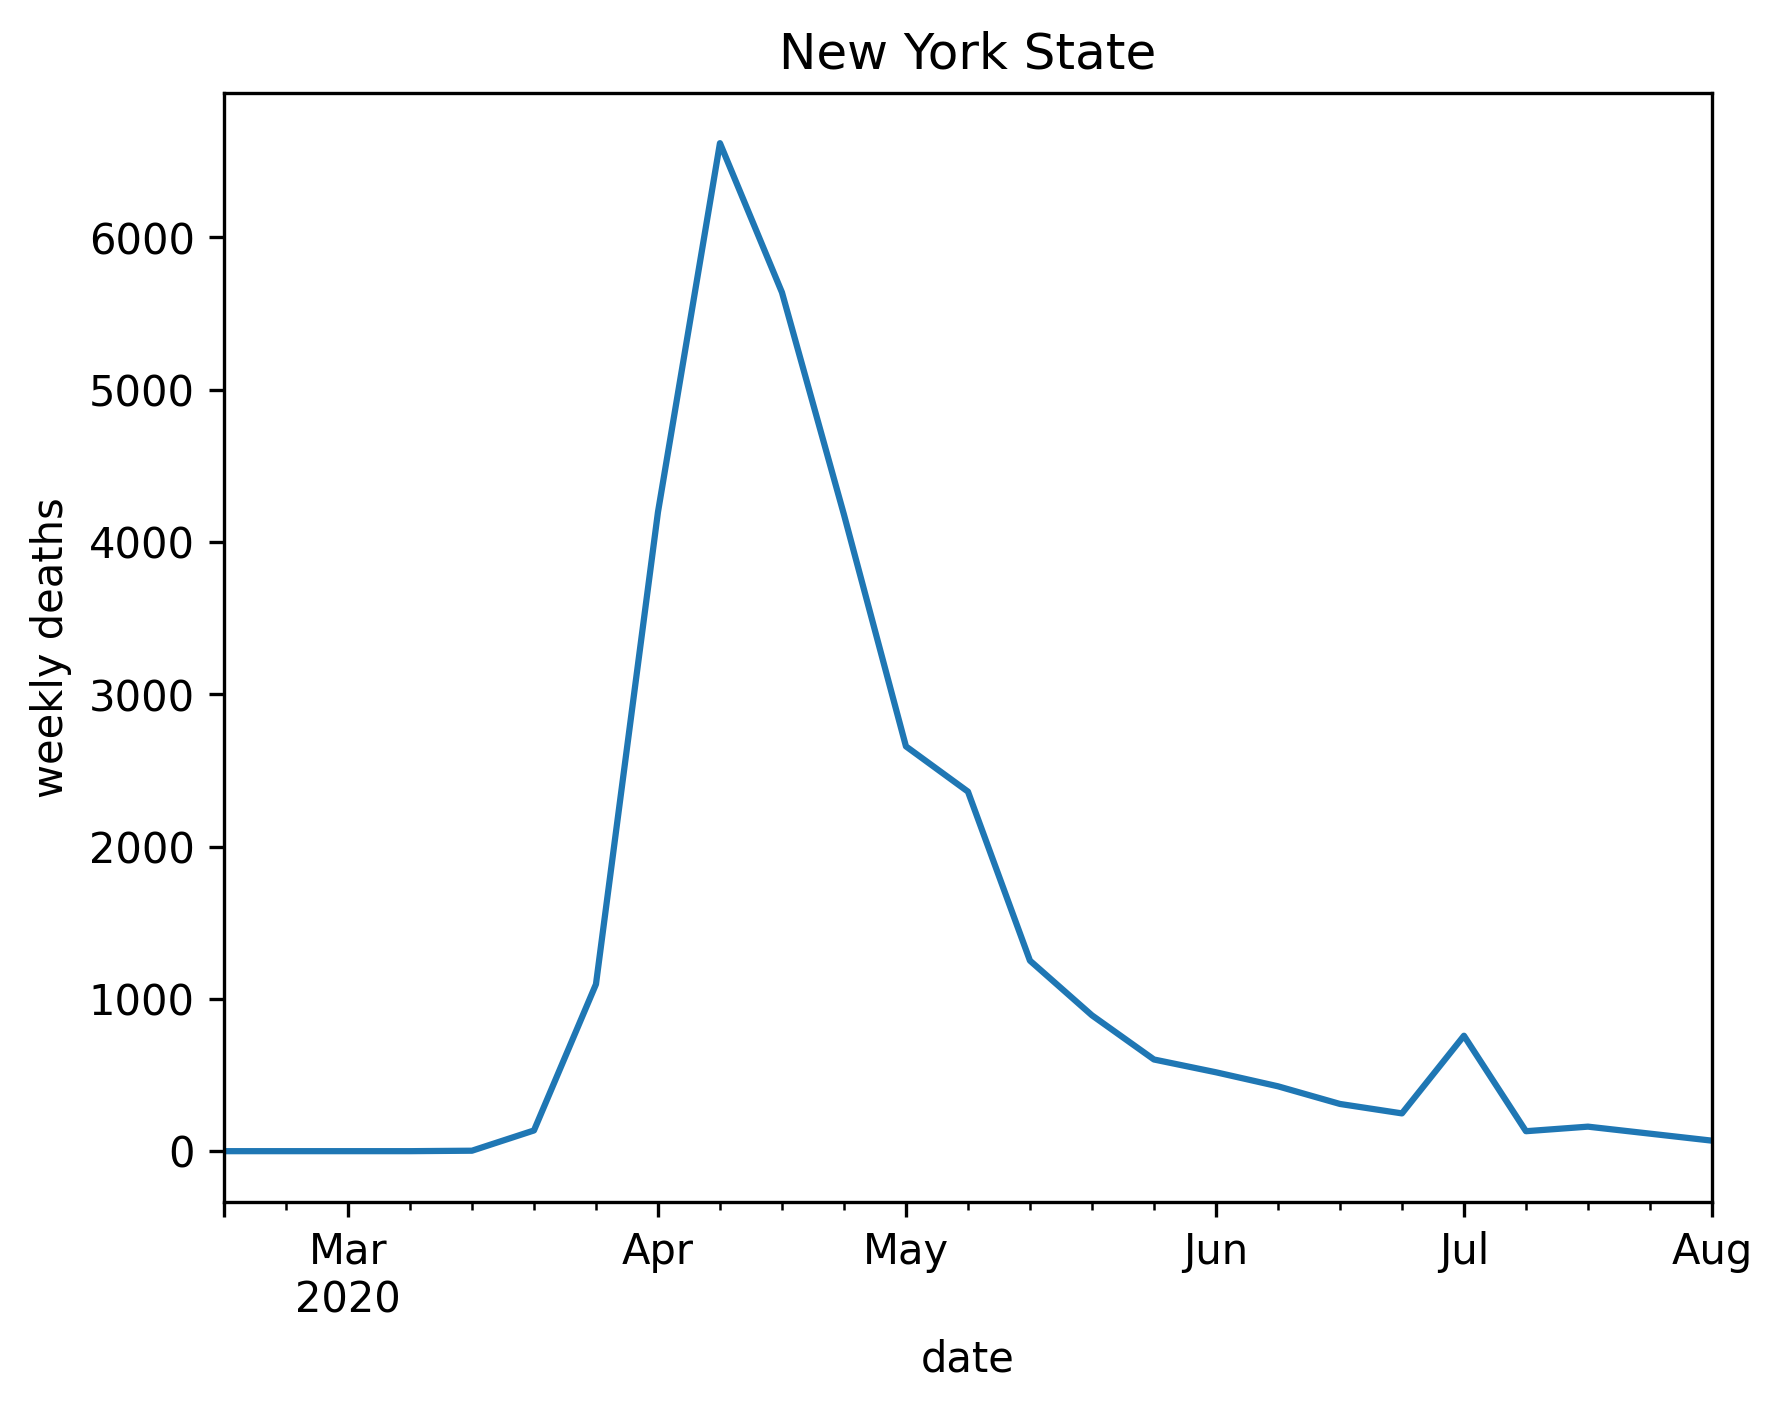

In [2]:
# import epidemic data 
epi_data = pd.read_csv("./data/ny_state/NY_deaths.csv")
epi_data.index = pd.to_datetime(epi_data.date)

fig, ax = plt.subplots(dpi=300)
epi_data.data.plot(ax=ax, title="New York State", ylabel="weekly deaths")

Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVID-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see REFS:

<Axes: title={'center': 'Contact reductions in New York State - COVID-19 First wave'}, xlabel='date', ylabel='$r(t)$'>

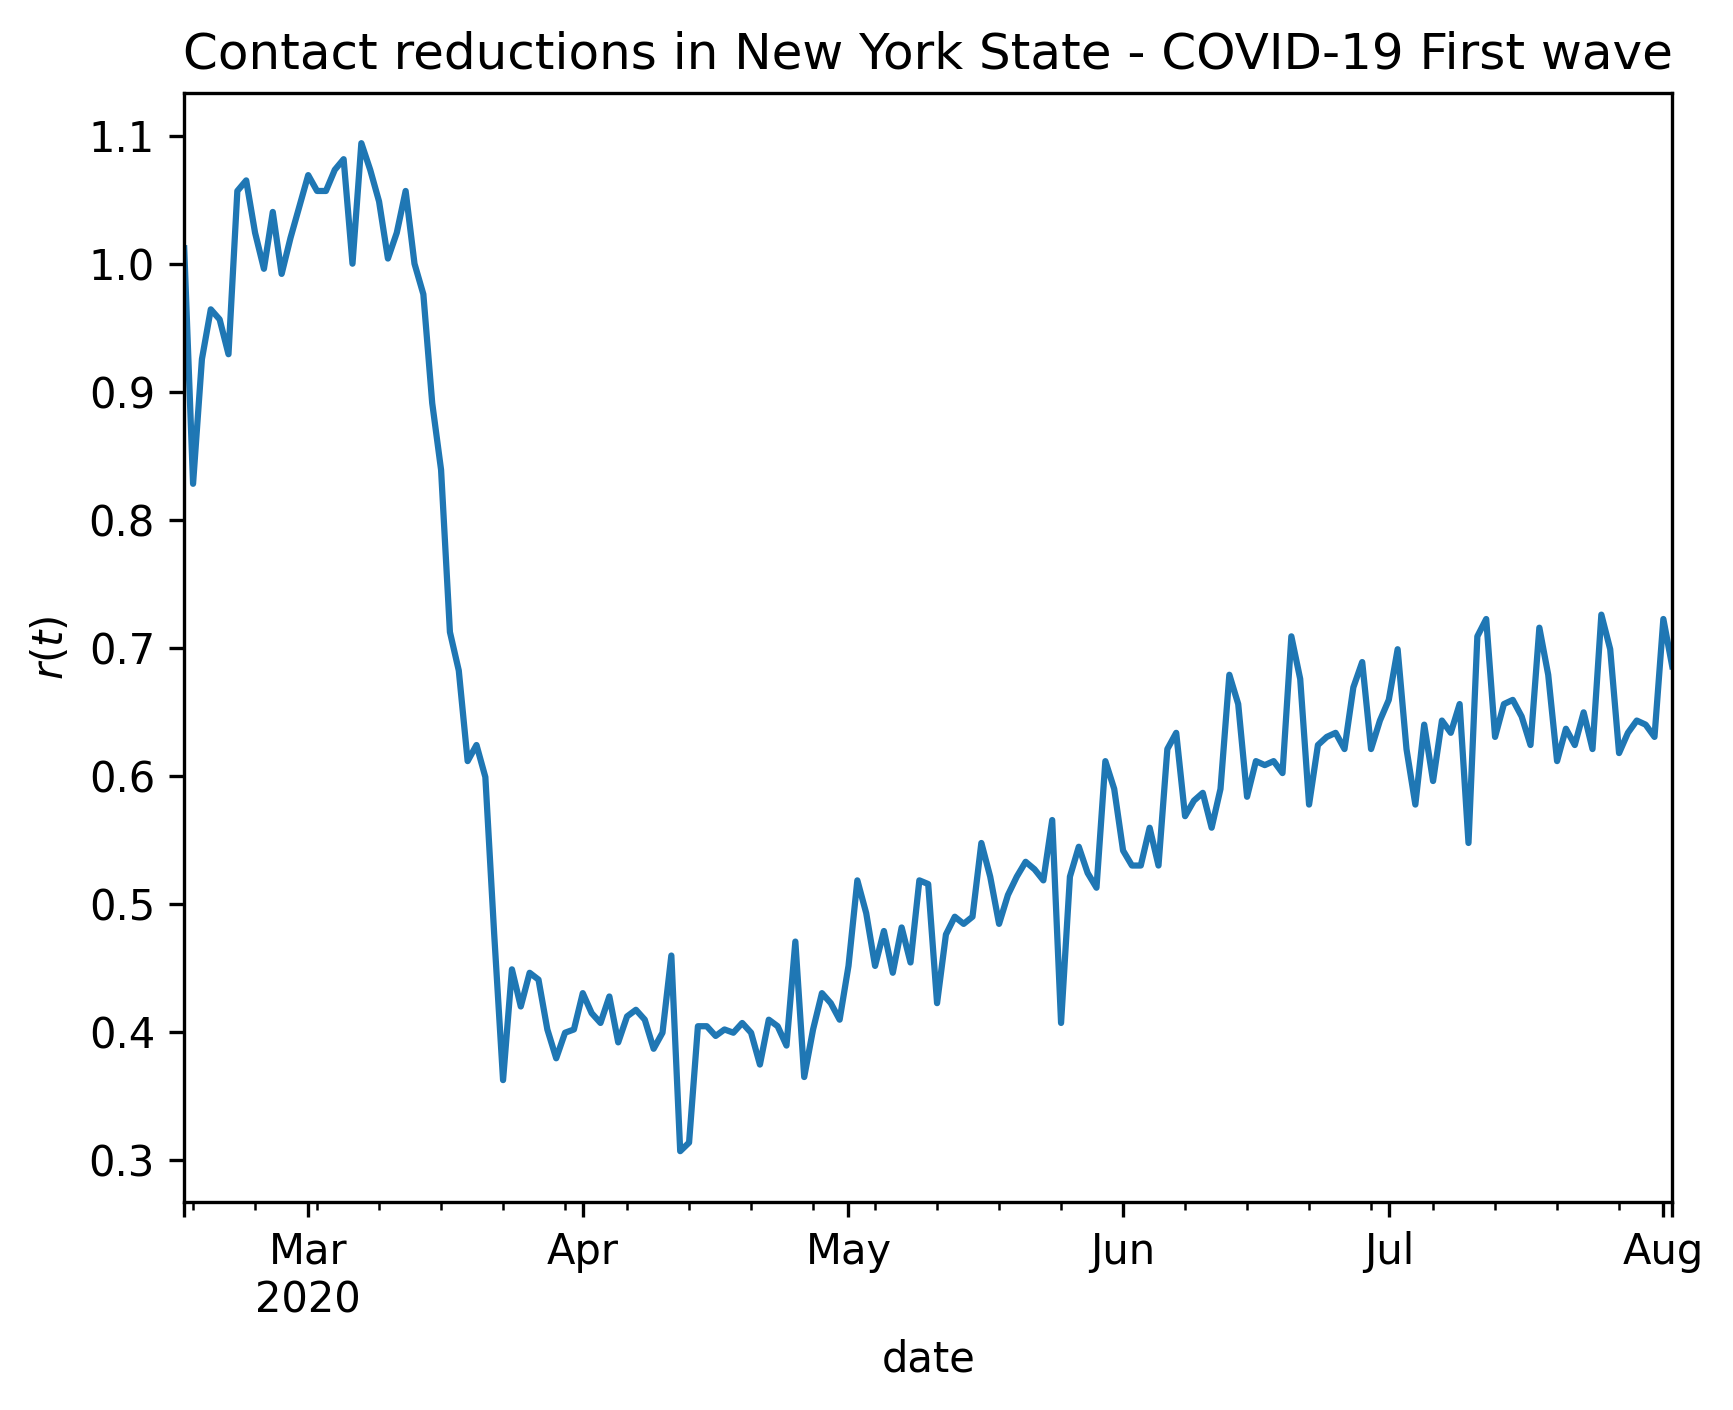

In [3]:
def compute_contact_reductions(mob_data, columns):
    return pd.DataFrame(data={'date': mob_data.date, 'r': (1 + mob_data[columns].mean(axis=1) / 100)**2})

# import google data and compute contacts reduction
mob_data = pd.read_csv(f'./data/ny_state/NY_google.csv')
mob_data = mob_data.loc[(mob_data.date >= epi_data.date.min()) & (mob_data.date <= epi_data.date.max())]
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])
contact_reductions.index = pd.to_datetime(contact_reductions.date)

fig, ax = plt.subplots(dpi=300)
contact_reductions.r.plot(ax=ax, title="Contact reductions in New York State - COVID-19 First wave", ylabel="$r(t)$")

We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

MODEL SCHEMA

The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [4]:
# create model 
model = EpiModel(compartments=["S", "E", "I", "R", "D0", "D1", "D2"])

# set population
population_nys = load_epydemix_population("United_States_New_York")
model.set_population(population_nys)

model.add_parameter(parameters_dict={"mu": 1. / 2.5, 
                                     "eps": 1. / 4., 
                                     "r": contact_reductions["r"].values, 
                                     "IFR": convert_to_2Darray([0.0000161, 0.0000695, 0.000768, 0.012625,0.0467])})

model.add_transition(source="S", target="E", rate="beta*r", agent="I")
model.add_transition(source="E", target="I", rate="eps")
model.add_transition(source="I", target="R", rate="mu*(1-IFR)")
model.add_transition(source="I", target="D0", rate="mu*IFR")
model.add_transition(source="D0", target="D1", rate="1./Delta*2")
model.add_transition(source="D1", target="D2", rate="1./Delta*2")
print(model)

EpiModel(name='EpiModel')
Compartments: 7
  S, E, I, R, D0, D1, D2
Transitions: 6
  Transitions between compartments:
    S -> E, rate: beta*r
    E -> I, rate: eps
    I -> R, rate: mu*(1-IFR)
    I -> D0, rate: mu*IFR
    D0 -> D1, rate: 1./Delta*2
    D1 -> D2, rate: 1./Delta*2
Parameters: 4
  Model parameters:
    mu: 0.4
    eps: 0.25
    r: [1.012036 0.8281   0.925444 0.964324 0.956484 0.929296 1.056784 1.065024
 1.024144 0.996004 1.0404   0.992016 1.0201   1.044484 1.069156 1.056784
 1.056784 1.073296 1.0816   1.       1.094116 1.073296 1.048576 1.004004
 1.024144 1.056784 1.       0.976144 0.891136 0.839056 0.712336 0.682276
 0.611524 0.6241   0.599076 0.4761   0.362404 0.4489   0.419904 0.446224
 0.440896 0.401956 0.379456 0.399424 0.401956 0.430336 0.414736 0.407044
 0.427716 0.391876 0.412164 0.417316 0.4096   0.386884 0.399424 0.459684
 0.306916 0.3136   0.404496 0.404496 0.3969   0.401956 0.399424 0.407044
 0.399424 0.374544 0.4096   0.404496 0.389376 0.470596 0.364816 0.4

In [5]:
def apply_seasonality(start_date, end_date, seasonality_min, seasonality_max=1):
    seasonality_factors = []
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
    for day in pd.date_range(start_date, end_date):
        day_max=datetime(day.year, 1, 15)
        s_r = seasonality_min / seasonality_max
        seasonality_factors.append(0.5 * ((1 - s_r) * np.sin(2 * np.pi / 365 * (day - day_max).days + 0.5 * np.pi) + 1 + s_r))
    return np.array(seasonality_factors)

def compute_beta(C, mu, R0): 
    return R0 * mu / np.linalg.eigvals(C).real.max()

def compute_R0(beta, mu, C): 
    return beta * np.linalg.eigvals(C).real.max() / mu

C = np.sum([c for _, c in model.population.contact_matrices.items()], axis=0)

We are almost ready for the calibration:

In [6]:
def custom_initial_conditions(epimodel, I0): 
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {"S": epimodel.population.Nk - infected_by_age, 
            "E": (infected_by_age / 2).astype(int),
            "I": (infected_by_age / 2).astype(int)}

def simulate_wrapper(parameters): 
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})
    # compute beta from R0 
    beta0 = compute_beta(C, parameters["epimodel"].parameters["mu"], parameters["R0"])
    # compute seasonality factor
    sesonal_factor = apply_seasonality(parameters["start_date"],  parameters["end_date"], parameters["seasonality_min"])
    parameters.update({"beta": beta0 * sesonal_factor})
    results = simulate(**parameters)
    # apply detection rate
    deaths = (results.transitions["D1_to_D2_total"] * parameters["detection_rate"]).astype(int)
    return {"data": deaths}


priors = {"R0": stats.uniform(1.5, 6.0 - 1.5), 
          "Delta": stats.randint(7, 28),
          "I0": stats.randint(1, 10000),
          "seasonality_min": stats.uniform(0.5, 1 - 0.5), 
          "detection_rate": stats.uniform(0.5, 1.0 - 0.5)}

simulation_dates = compute_simulation_dates(start_date=epi_data.date.values[0], end_date=epi_data.date.values[-1])
parameters = {"epimodel": model, 
              "start_date": epi_data.date.values[0], 
              "end_date": epi_data.date.values[-1], 
              "resample_frequency": "W"}

In [100]:
results = calibrate(strategy="abc_smc", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    distance_function=wmape,
                    parameters=parameters, 
                    observed_data={"data": epi_data["data"].values},  
                    num_particles=100, 
                    max_generations=8)

Running generation 1, epsilon: 0.8260835985047422
	Elapsed time: 00:00:31
Running generation 2, epsilon: 0.7015199728134944
	Elapsed time: 00:00:53
Running generation 3, epsilon: 0.5986746578516482
	Elapsed time: 00:01:03
Running generation 4, epsilon: 0.5521023201211035
	Elapsed time: 00:00:45
Running generation 5, epsilon: 0.5072754796255676
	Elapsed time: 00:03:28
Running generation 6, epsilon: 0.4754394636843894
	Elapsed time: 00:01:05
Running generation 7, epsilon: 0.4334548487750626
	Elapsed time: 00:04:45
Running generation 8, epsilon: 0.4135283759152275
	Elapsed time: 00:01:21


In [8]:
results_rejection = calibrate(strategy="abc_rejection", 
                    simulation_function=simulate_wrapper, 
                    priors=priors, 
                    distance_function=wmape,
                    parameters=parameters, 
                    observed_data={"data": epi_data["data"].values},  
                    num_particles=100, 
                    epsilon=0.5)

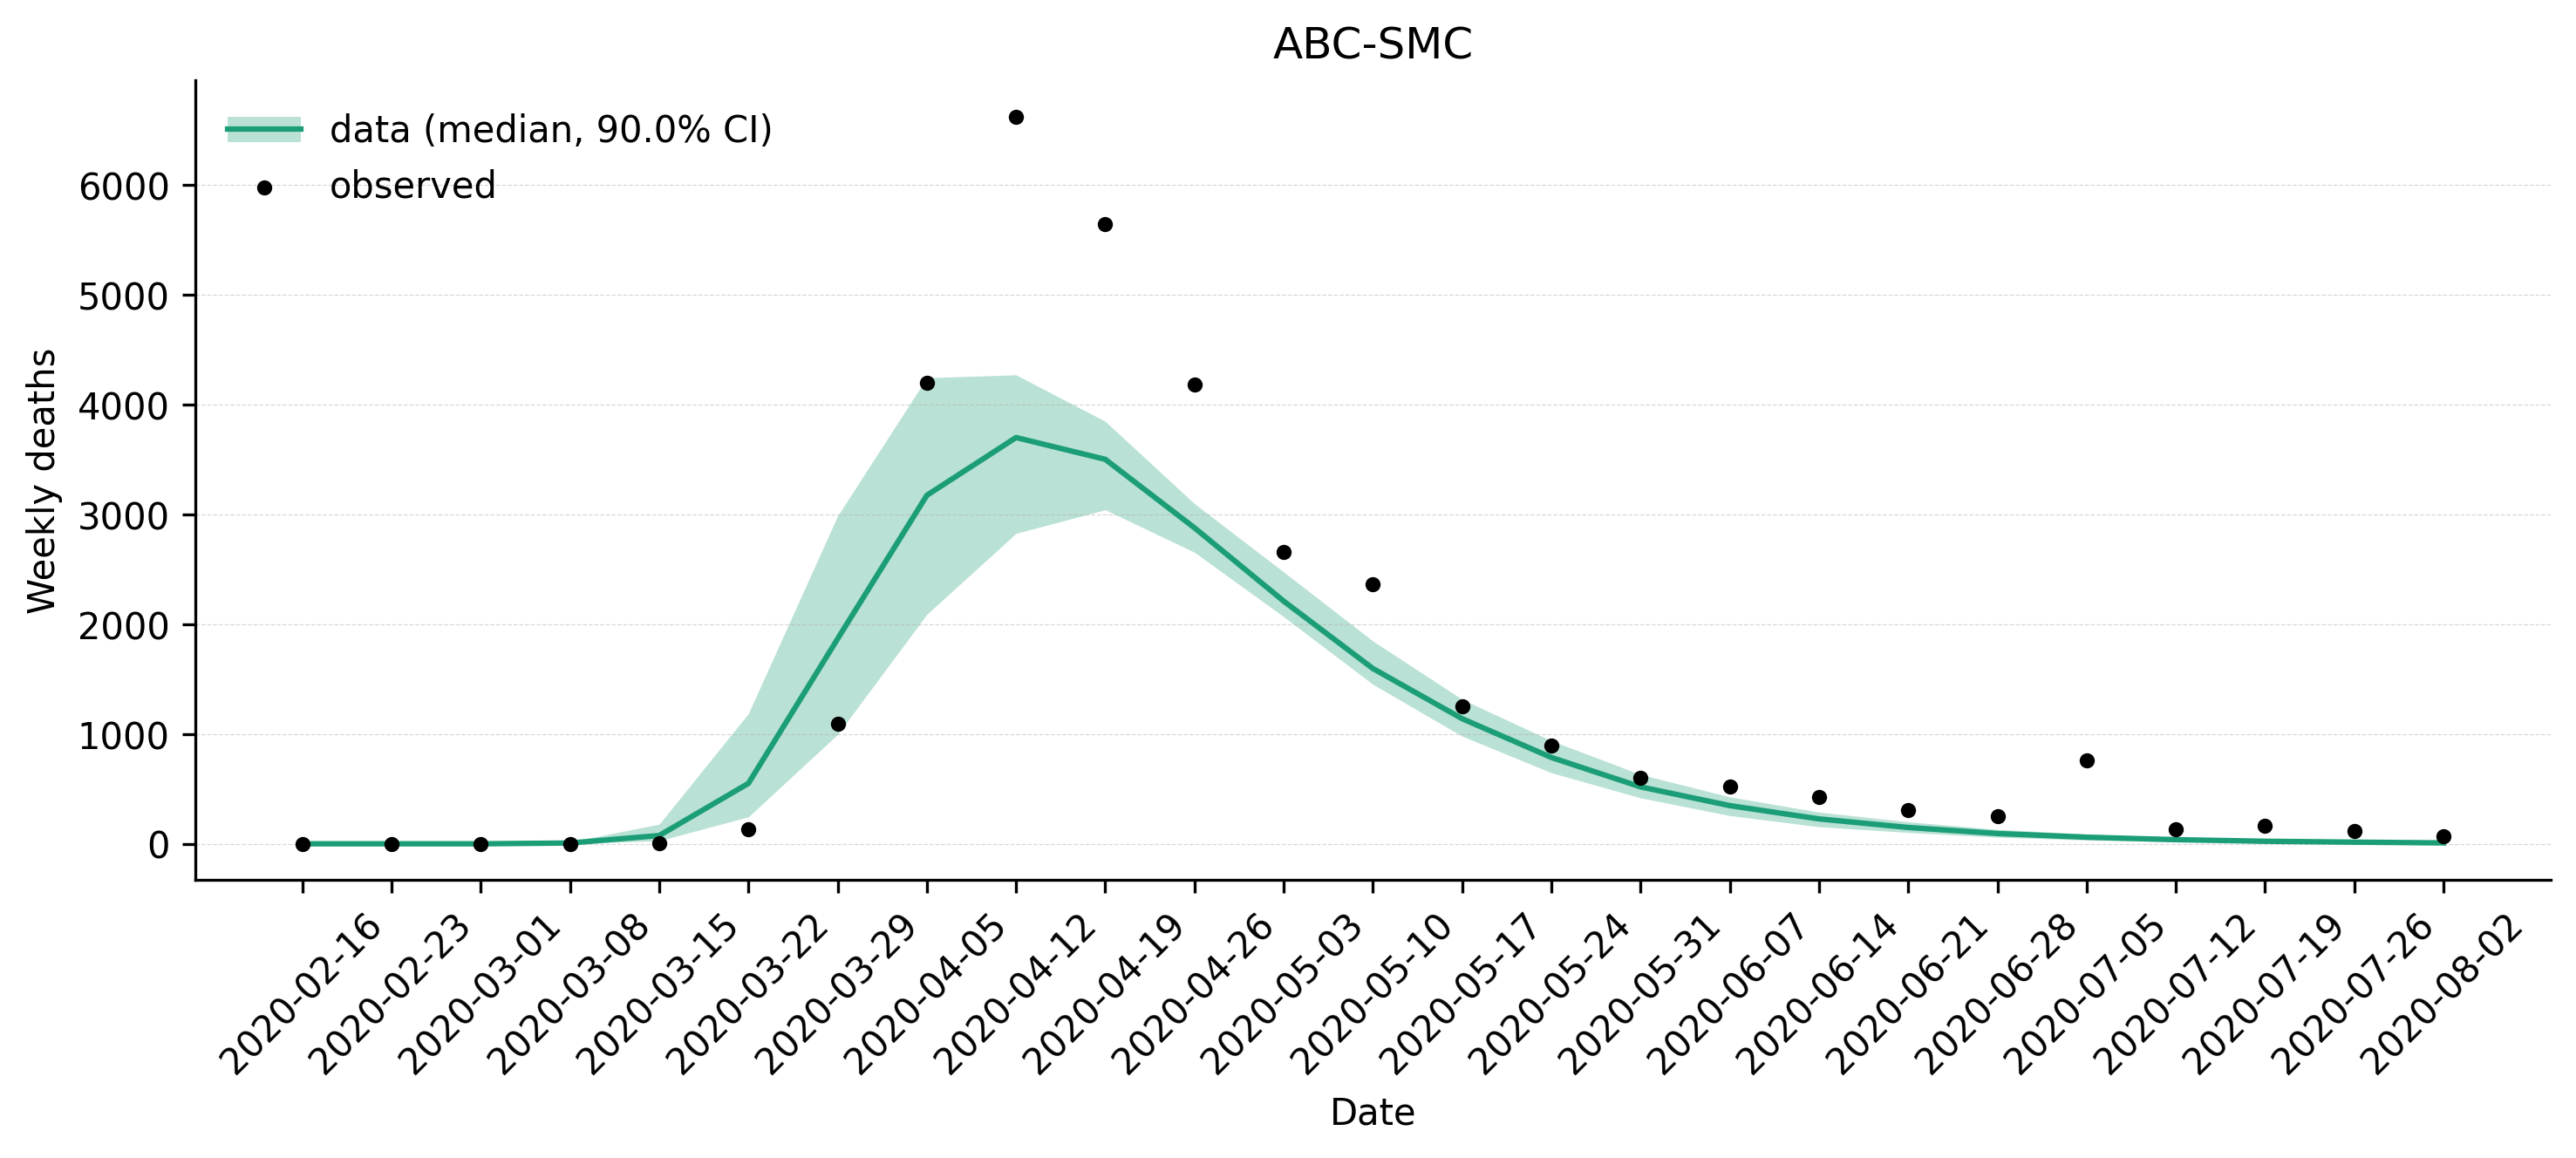

In [101]:
ax = plot_quantiles(results.get_calibration_quantiles(dates=epi_data.date.values), 
                    data=epi_data, columns="data", title="ABC-SMC", show_data=True, 
                    xlabel="Date", ylabel="Weekly deaths")   
ax.tick_params(axis='x', labelrotation=45)


<Axes: xlabel='R0', ylabel='Density'>

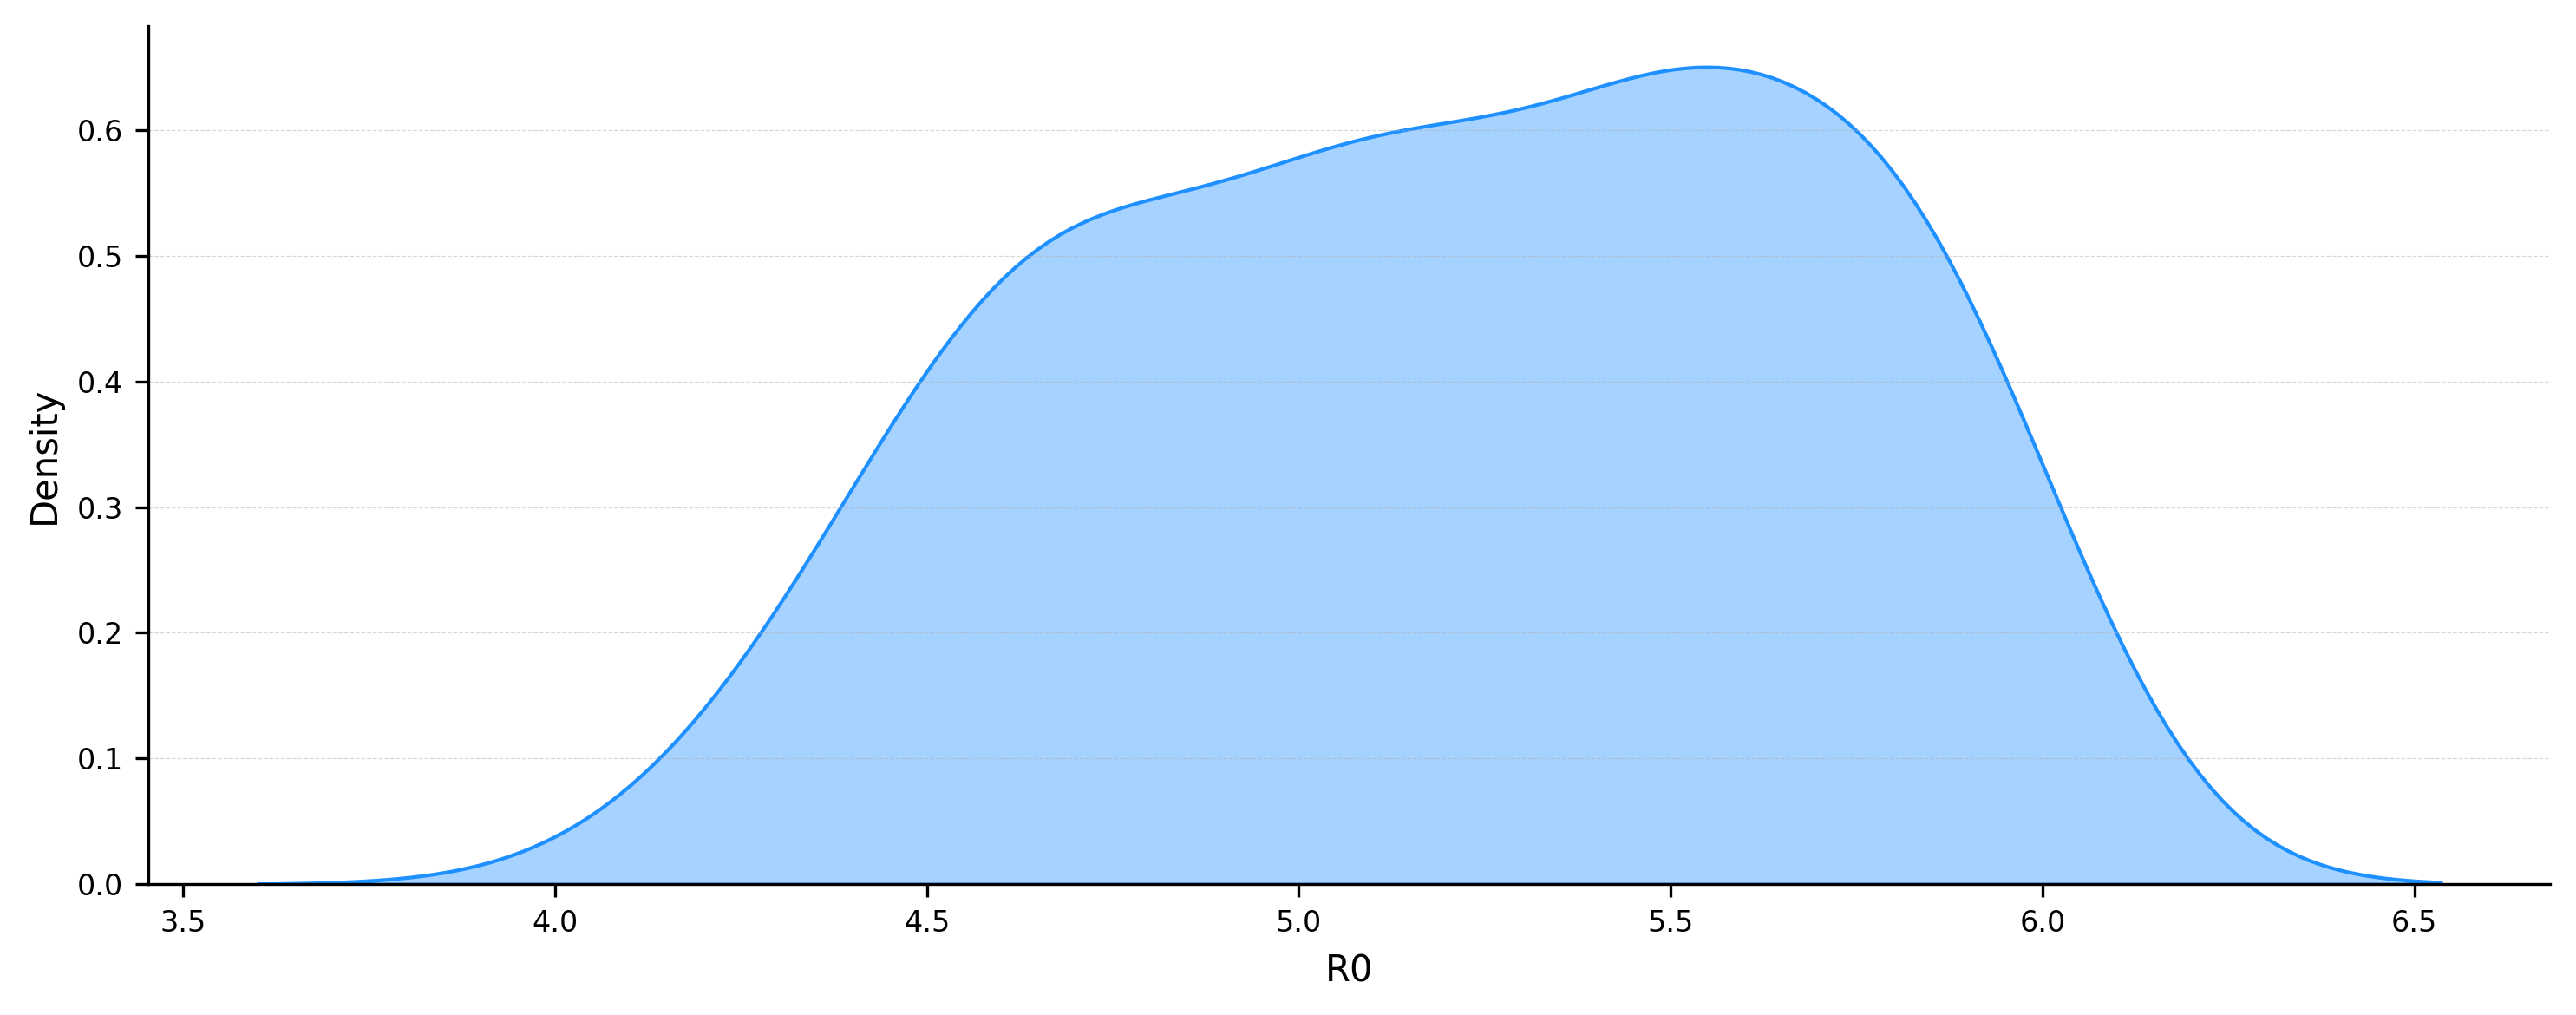

In [102]:
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde")

<Axes: xlabel='seasonality_min', ylabel='Density'>

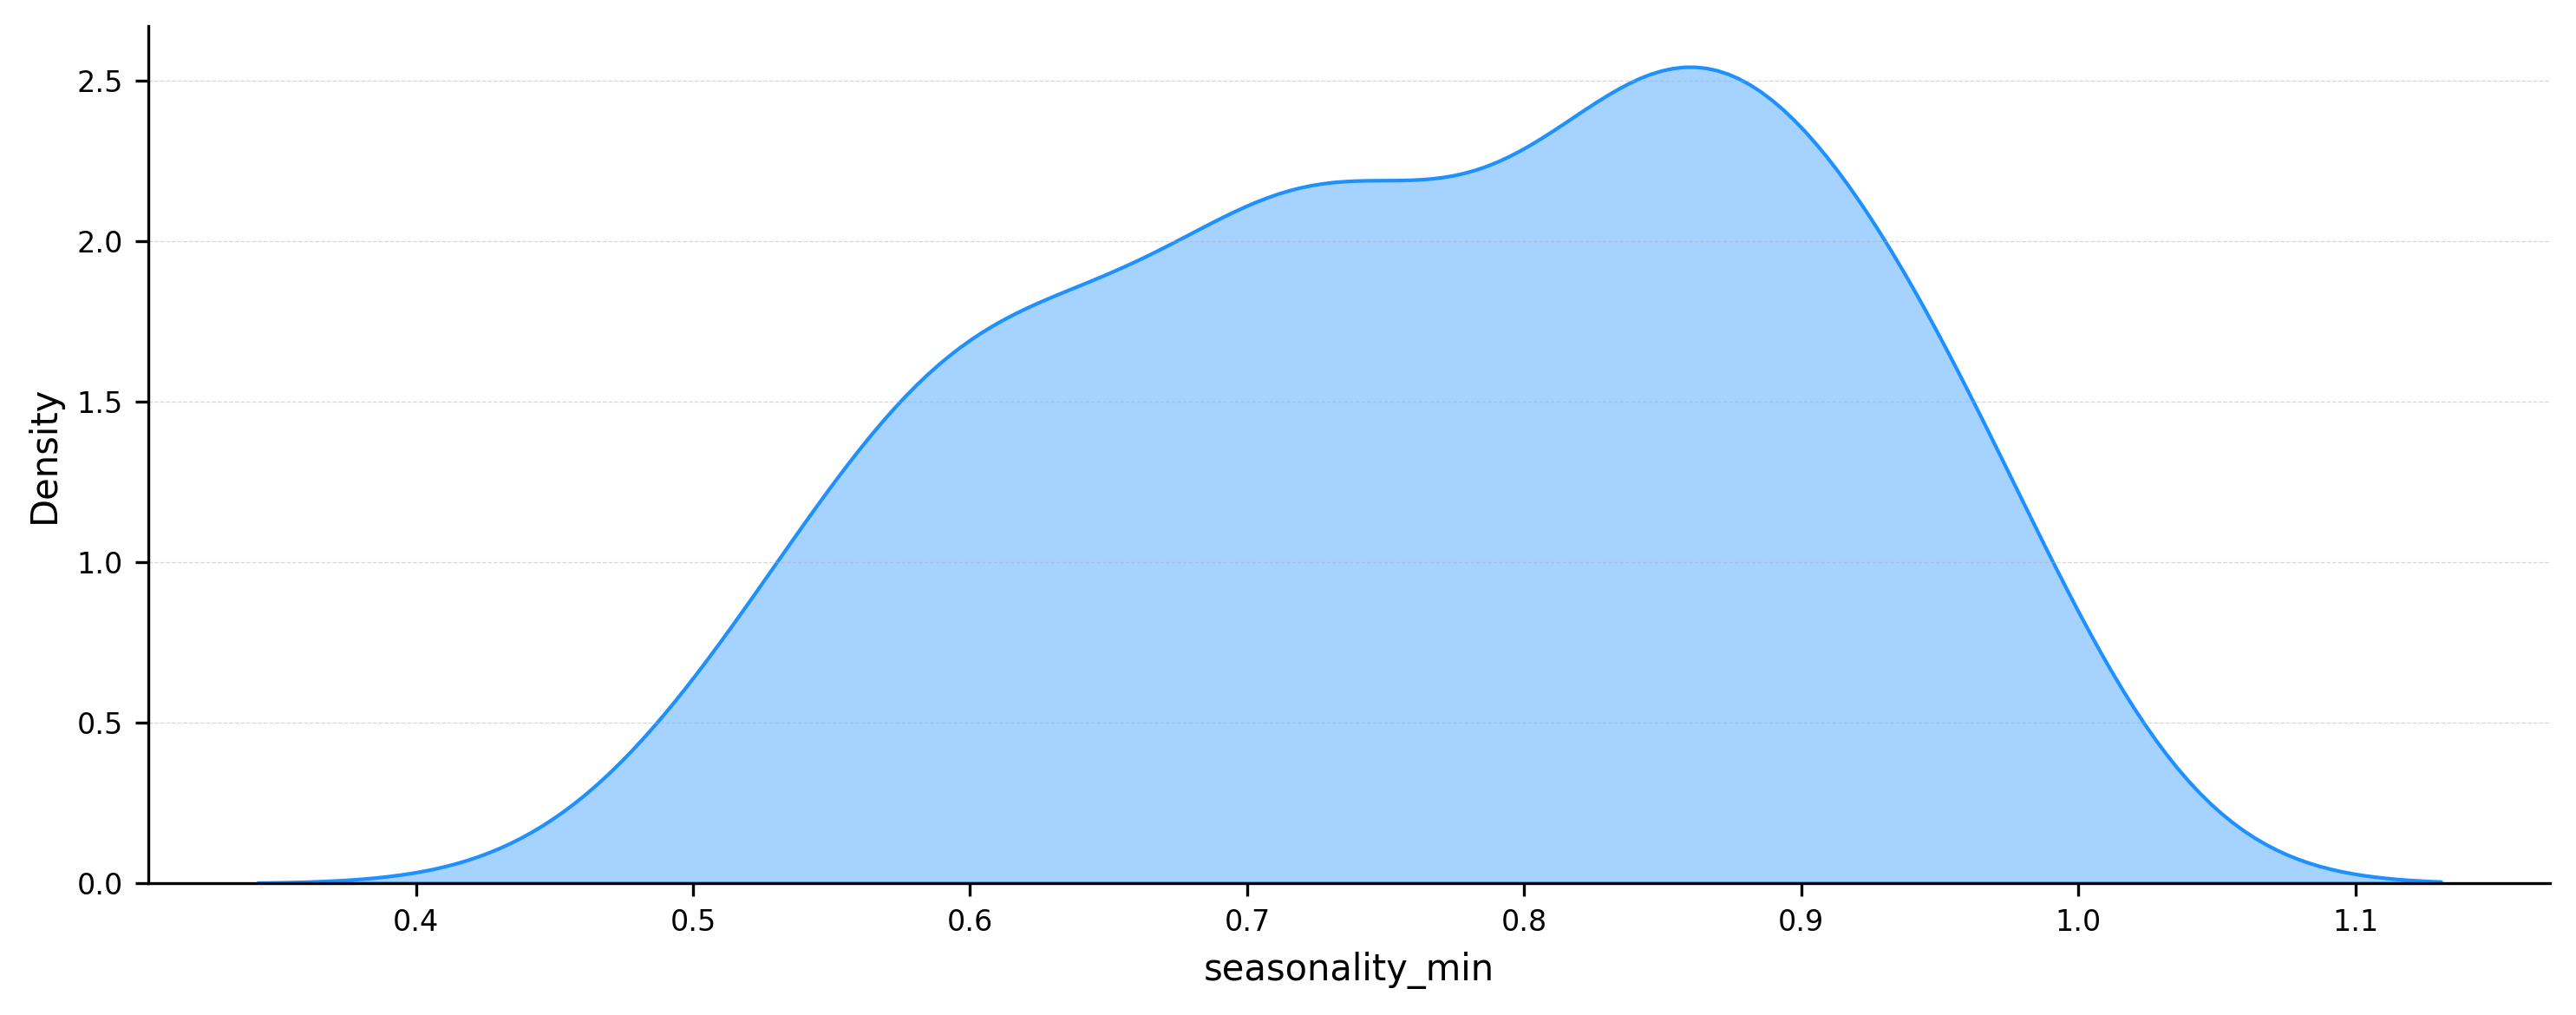

In [103]:
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde")

<Axes: title={'center': 'Joint Distribution\nDelta vs I0'}, xlabel='Delta', ylabel='I0'>

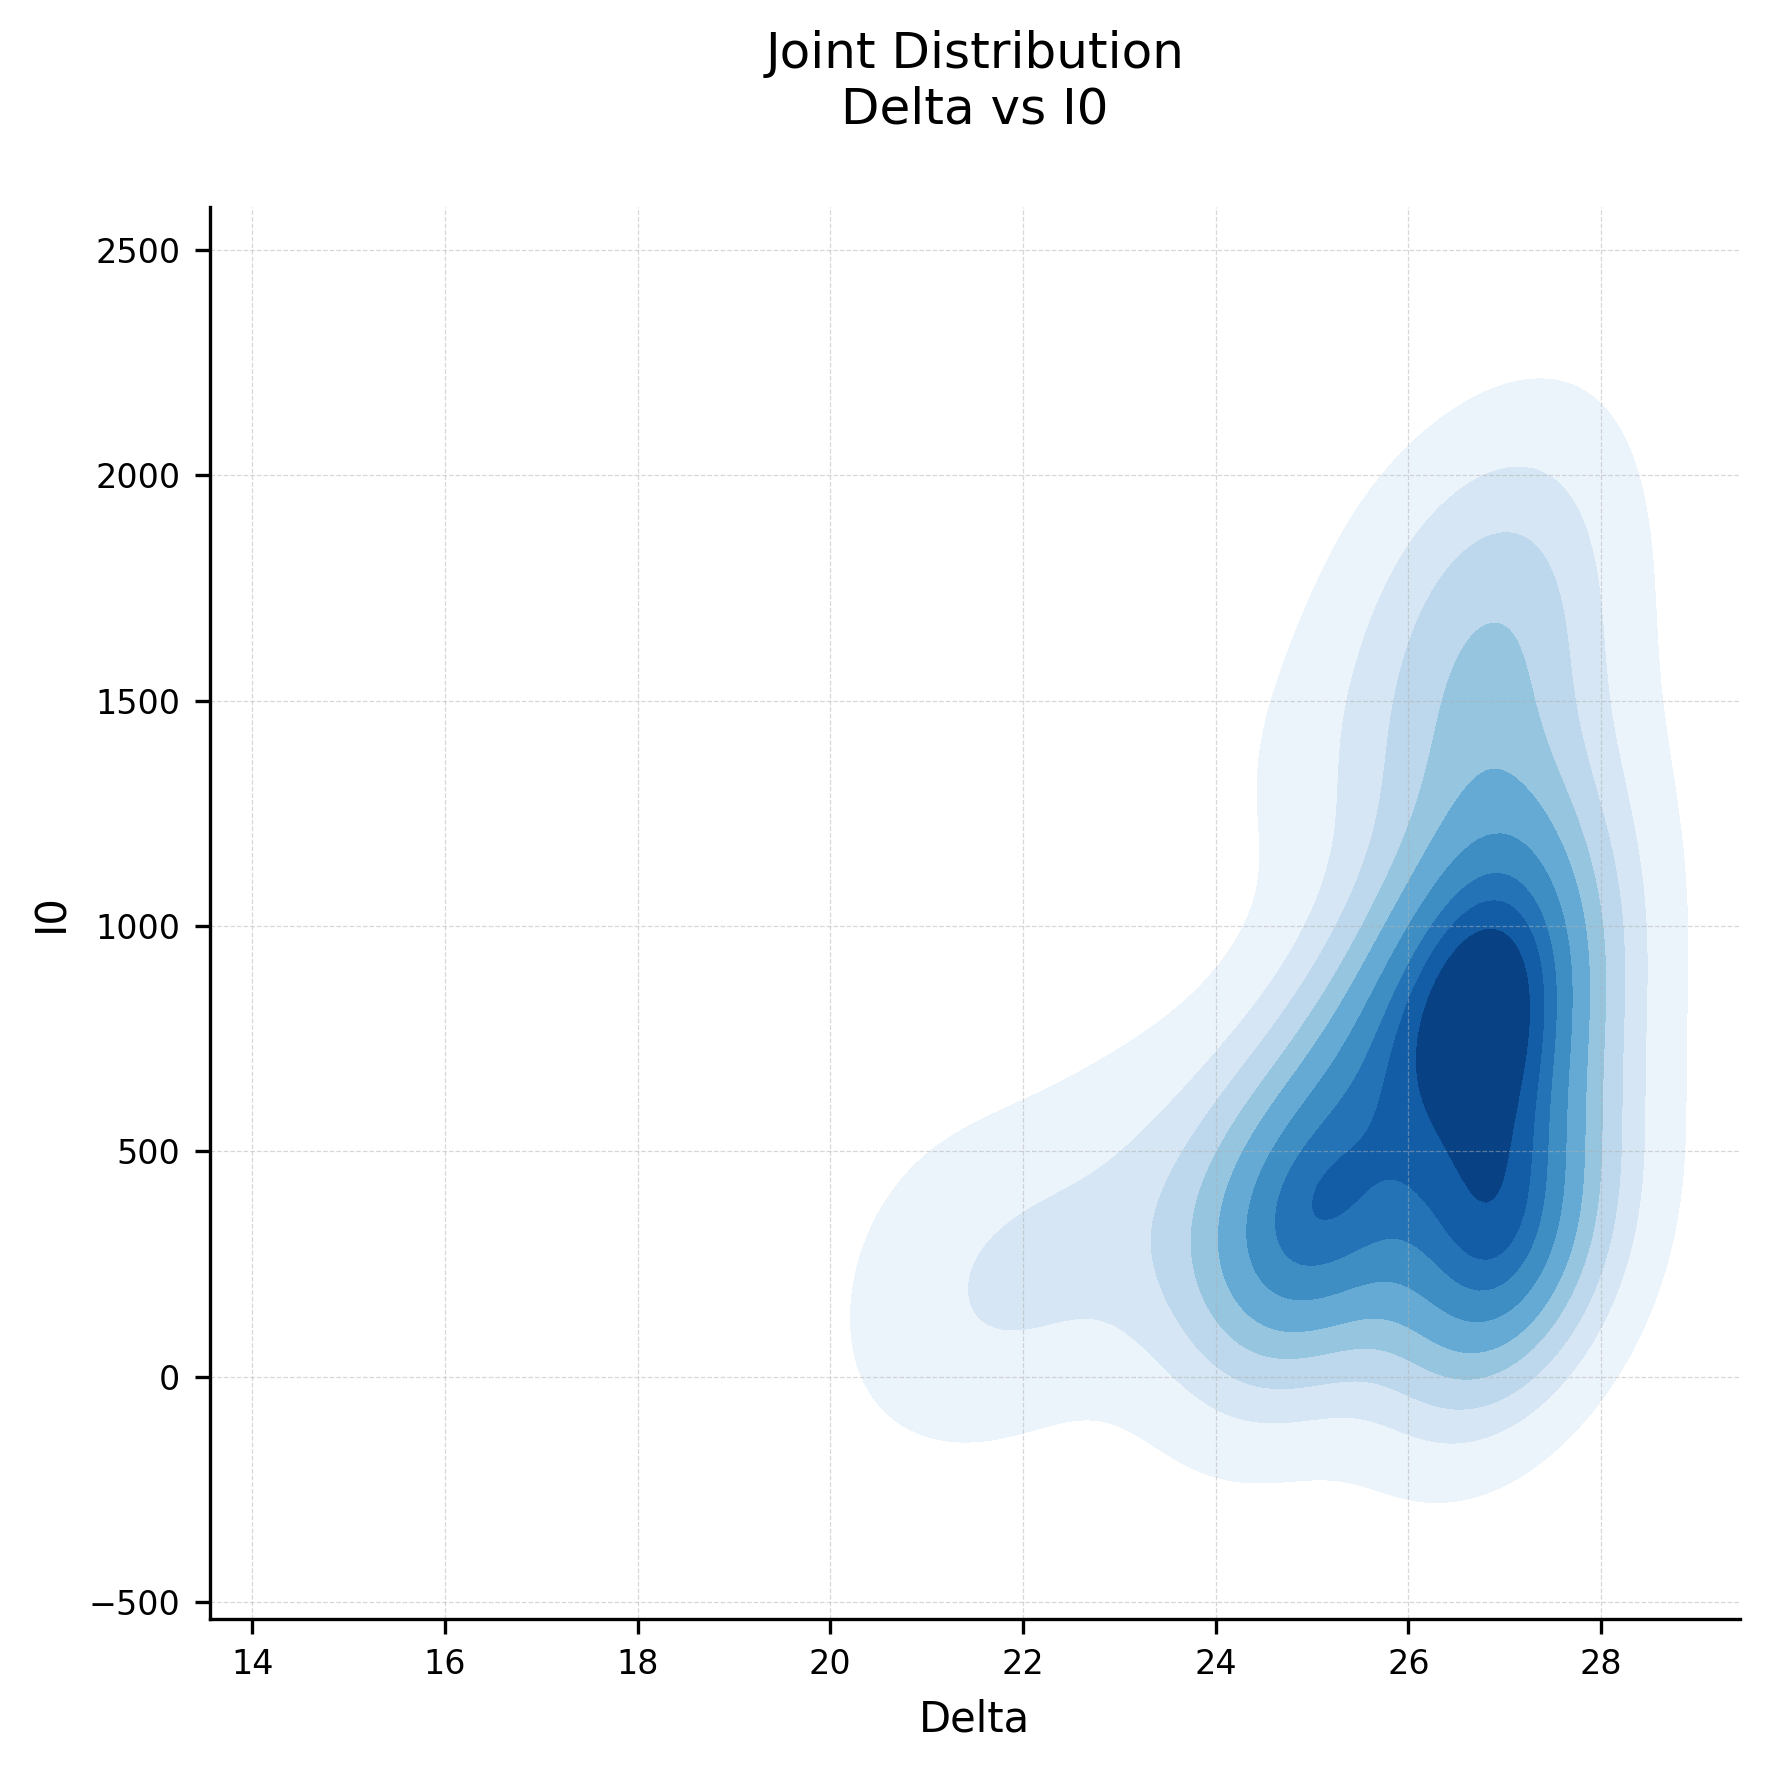

In [104]:
plot_posterior_distribution_2d(results.get_posterior_distribution(), "Delta", "I0", kind="kde")

In [112]:
import pyabc
import uuid
import os
from pyabc import RV, Distribution, DiscreteJumpTransition, MultivariateNormalTransition, AggregatedTransition
import tempfile
from pyabc.sampler import MulticoreEvalParallelSampler

def make_model(epimodel, param): 
    def model(p): 
        # run model 
        model_param = {**p, **param}
        return epimodel(model_param)
    return model


def wmape_pyabc(sim_data, actual_data) -> float:
    return np.sum(np.abs(actual_data['data'] - sim_data['data'])) / np.sum(np.abs(actual_data['data']))


pyabc_priors = Distribution(R0=RV("uniform", 1.5, 6.0 - 1.5),
                            Delta=RV('rv_discrete', values=(np.arange(7, 28), [1 / 21] * 21)),
                            I0=RV('rv_discrete', values=(np.arange(1, 10000), [1 / 9999] * 9999)), 
                            seasonality_min=RV("uniform", 0.5, 1.0 - 0.5), 
                            detection_rate=RV("uniform", 0.5, 1.0 - 0.5))

transitions = AggregatedTransition(mapping={"I0": DiscreteJumpTransition(domain=np.arange(1, 10000), p_stay=0.7), 
                                            "R0": MultivariateNormalTransition(), 
                                            "Delta": DiscreteJumpTransition(domain=np.arange(7, 28), p_stay=0.7),
                                            "seasonality_min": MultivariateNormalTransition(), 
                                            "detection_rate": MultivariateNormalTransition()})


abc = pyabc.ABCSMC(make_model(simulate_wrapper, parameters), 
                    pyabc_priors, 
                    distance_function=wmape_pyabc, 
                    transitions=transitions, 
                    population_size=100, 
                    sampler=MulticoreEvalParallelSampler(n_procs=8))

db_path = os.path.join(tempfile.gettempdir(), "test_1.db")
abc.new("sqlite:///" + db_path, {"data": epi_data["data"].values})
history = abc.run(max_nr_populations=7)


ABC.Sampler INFO: Parallelize sampling on 8 processes.


ABC.History INFO: Start <ABCSMC id=15, start_time=2025-01-27 11:15:09>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 7.88037938e-01.
ABC INFO: Accepted: 100 / 232 = 4.3103e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 6.68448207e-01.
ABC INFO: Accepted: 100 / 269 = 3.7175e-01, ESS: 1.6784e+01.
ABC INFO: t: 2, eps: 5.99322781e-01.
ABC INFO: Accepted: 100 / 280 = 3.5714e-01, ESS: 1.2930e+01.
ABC INFO: t: 3, eps: 5.68687733e-01.
ABC INFO: Accepted: 100 / 314 = 3.1847e-01, ESS: 8.4241e+00.
ABC INFO: t: 4, eps: 5.14187461e-01.
ABC INFO: Accepted: 100 / 410 = 2.4390e-01, ESS: 8.6478e+00.
ABC INFO: t: 5, eps: 4.66675349e-01.
ABC INFO: Accepted: 100 / 502 = 1.9920e-01, ESS: 4.7896e+00.
ABC INFO: t: 6, eps: 4.61810802e-01.
ABC INFO: Accepted: 100 / 446 = 2.2422e-01, ESS: 5.8555e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=15, duration=0:09:44.155360, end_time=2025-01-27 11:24:53>


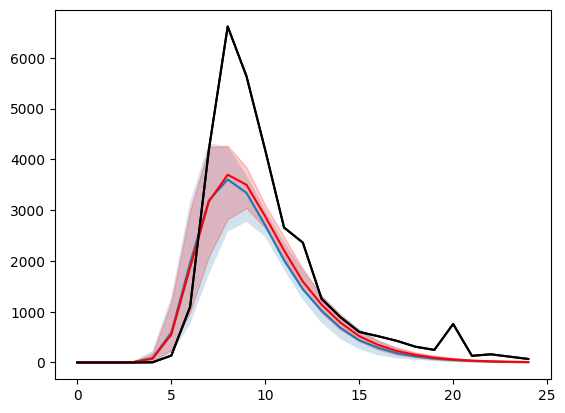

In [113]:
samples = np.array([d["data"] for d in history.get_weighted_sum_stats()[1]])
xs = np.arange(len(samples[0]))
plt.plot(xs, np.median(samples, axis=0))
plt.fill_between(xs, np.percentile(samples, 5.0, axis=0), np.percentile(samples, 95.0, axis=0), alpha=0.2)
plt.plot(xs, epi_data["data"].values, color="black")

epx_res = results.get_calibration_quantiles()

median_epx_res = epx_res.loc[epx_res["quantile"] == 0.5]
plt.plot(xs, median_epx_res["data"], color="red")
plt.fill_between(xs, epx_res.loc[epx_res["quantile"] == 0.05]["data"], epx_res.loc[epx_res["quantile"] == 0.95]["data"], alpha=0.2, color="red")
plt.plot(xs, epi_data["data"].values, color="black")

<Axes: xlabel='R0', ylabel='Density'>

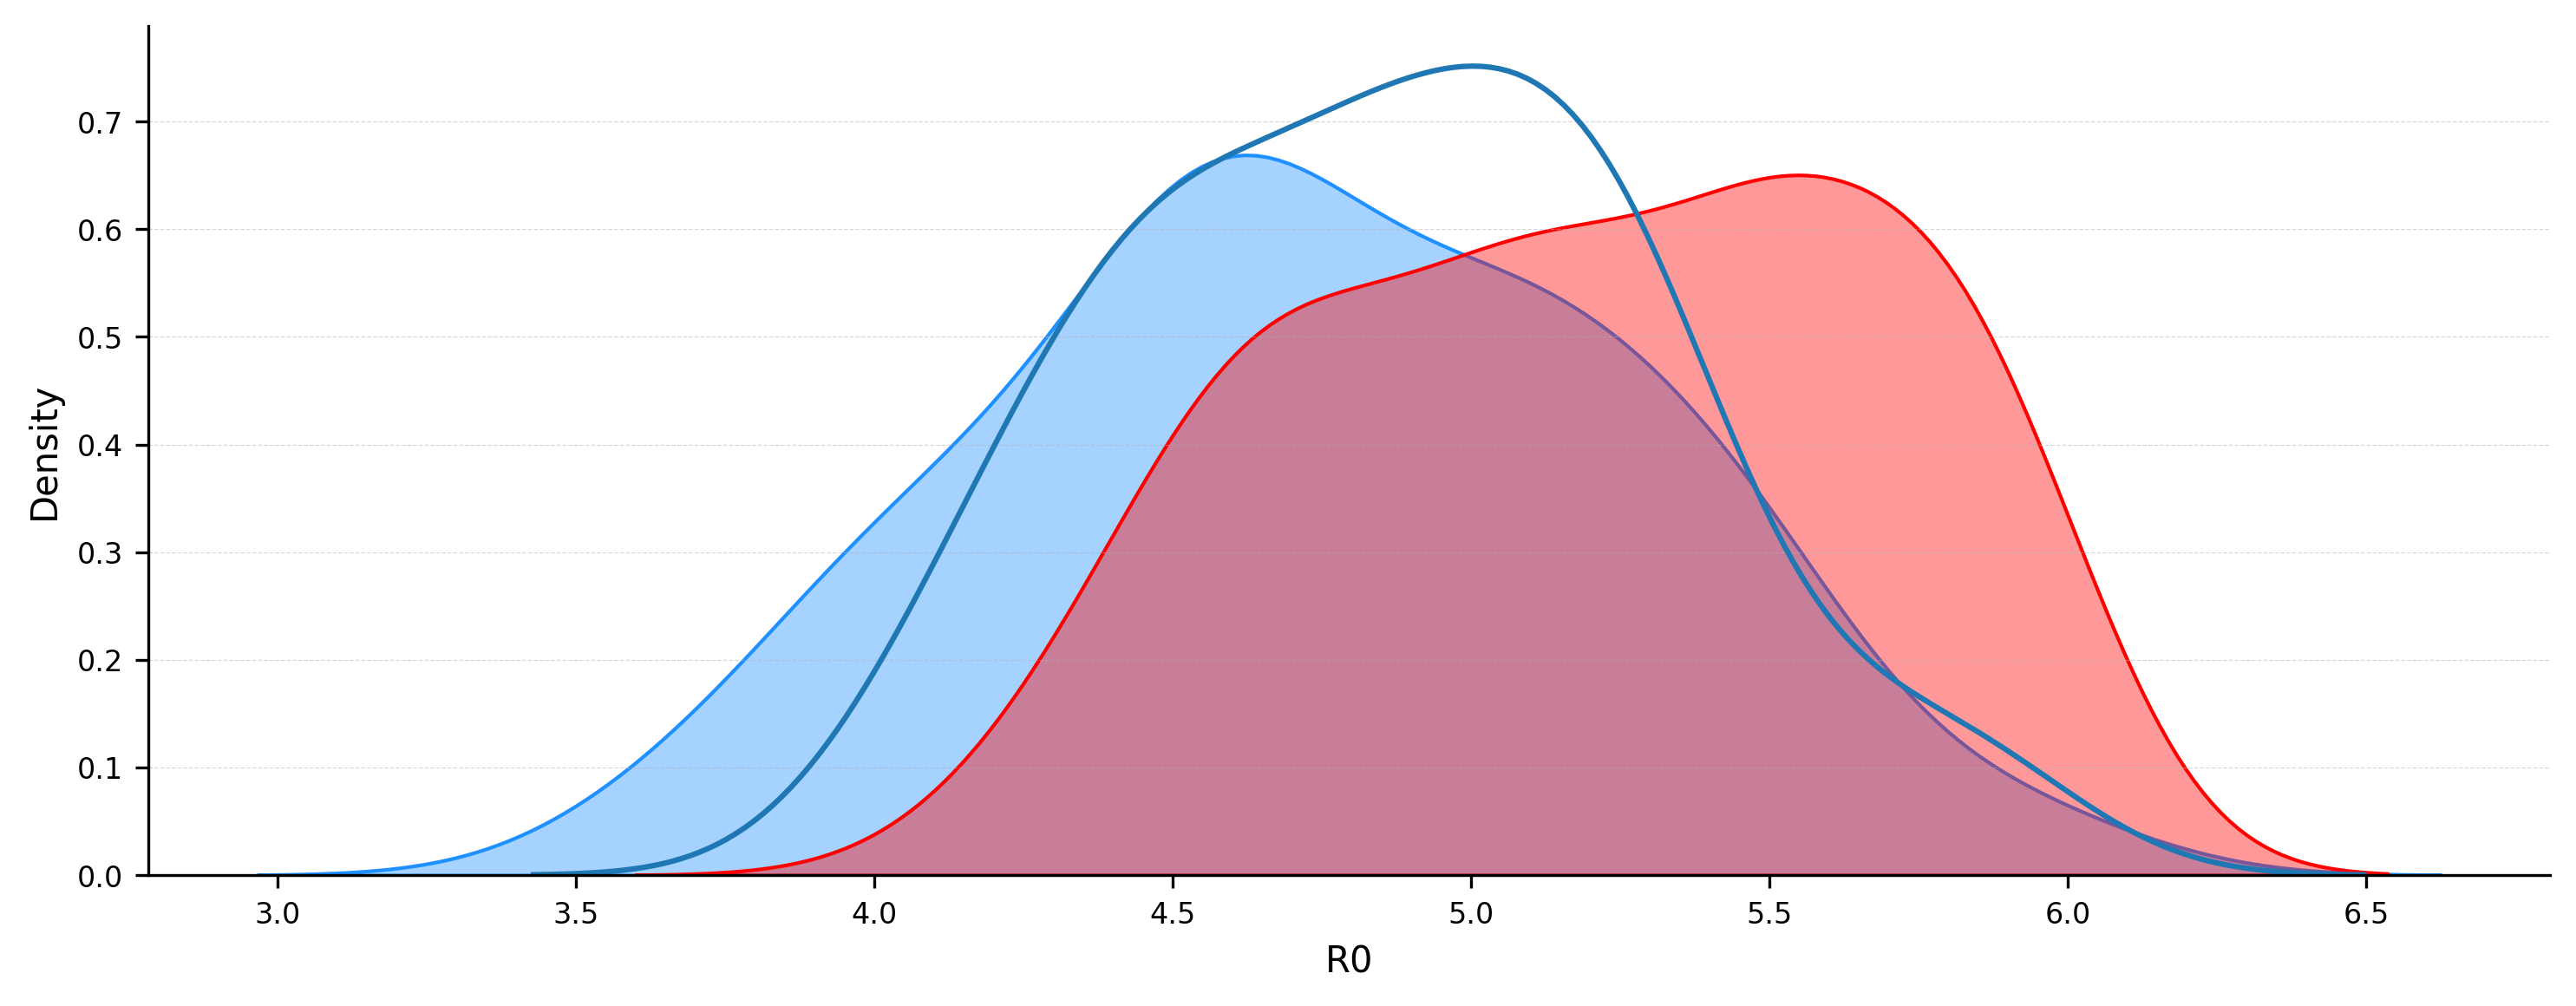

In [114]:
posterior_pyabc = history.get_distribution()[0]

import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "R0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["R0"], ax=ax)

<Axes: xlabel='I0', ylabel='Density'>

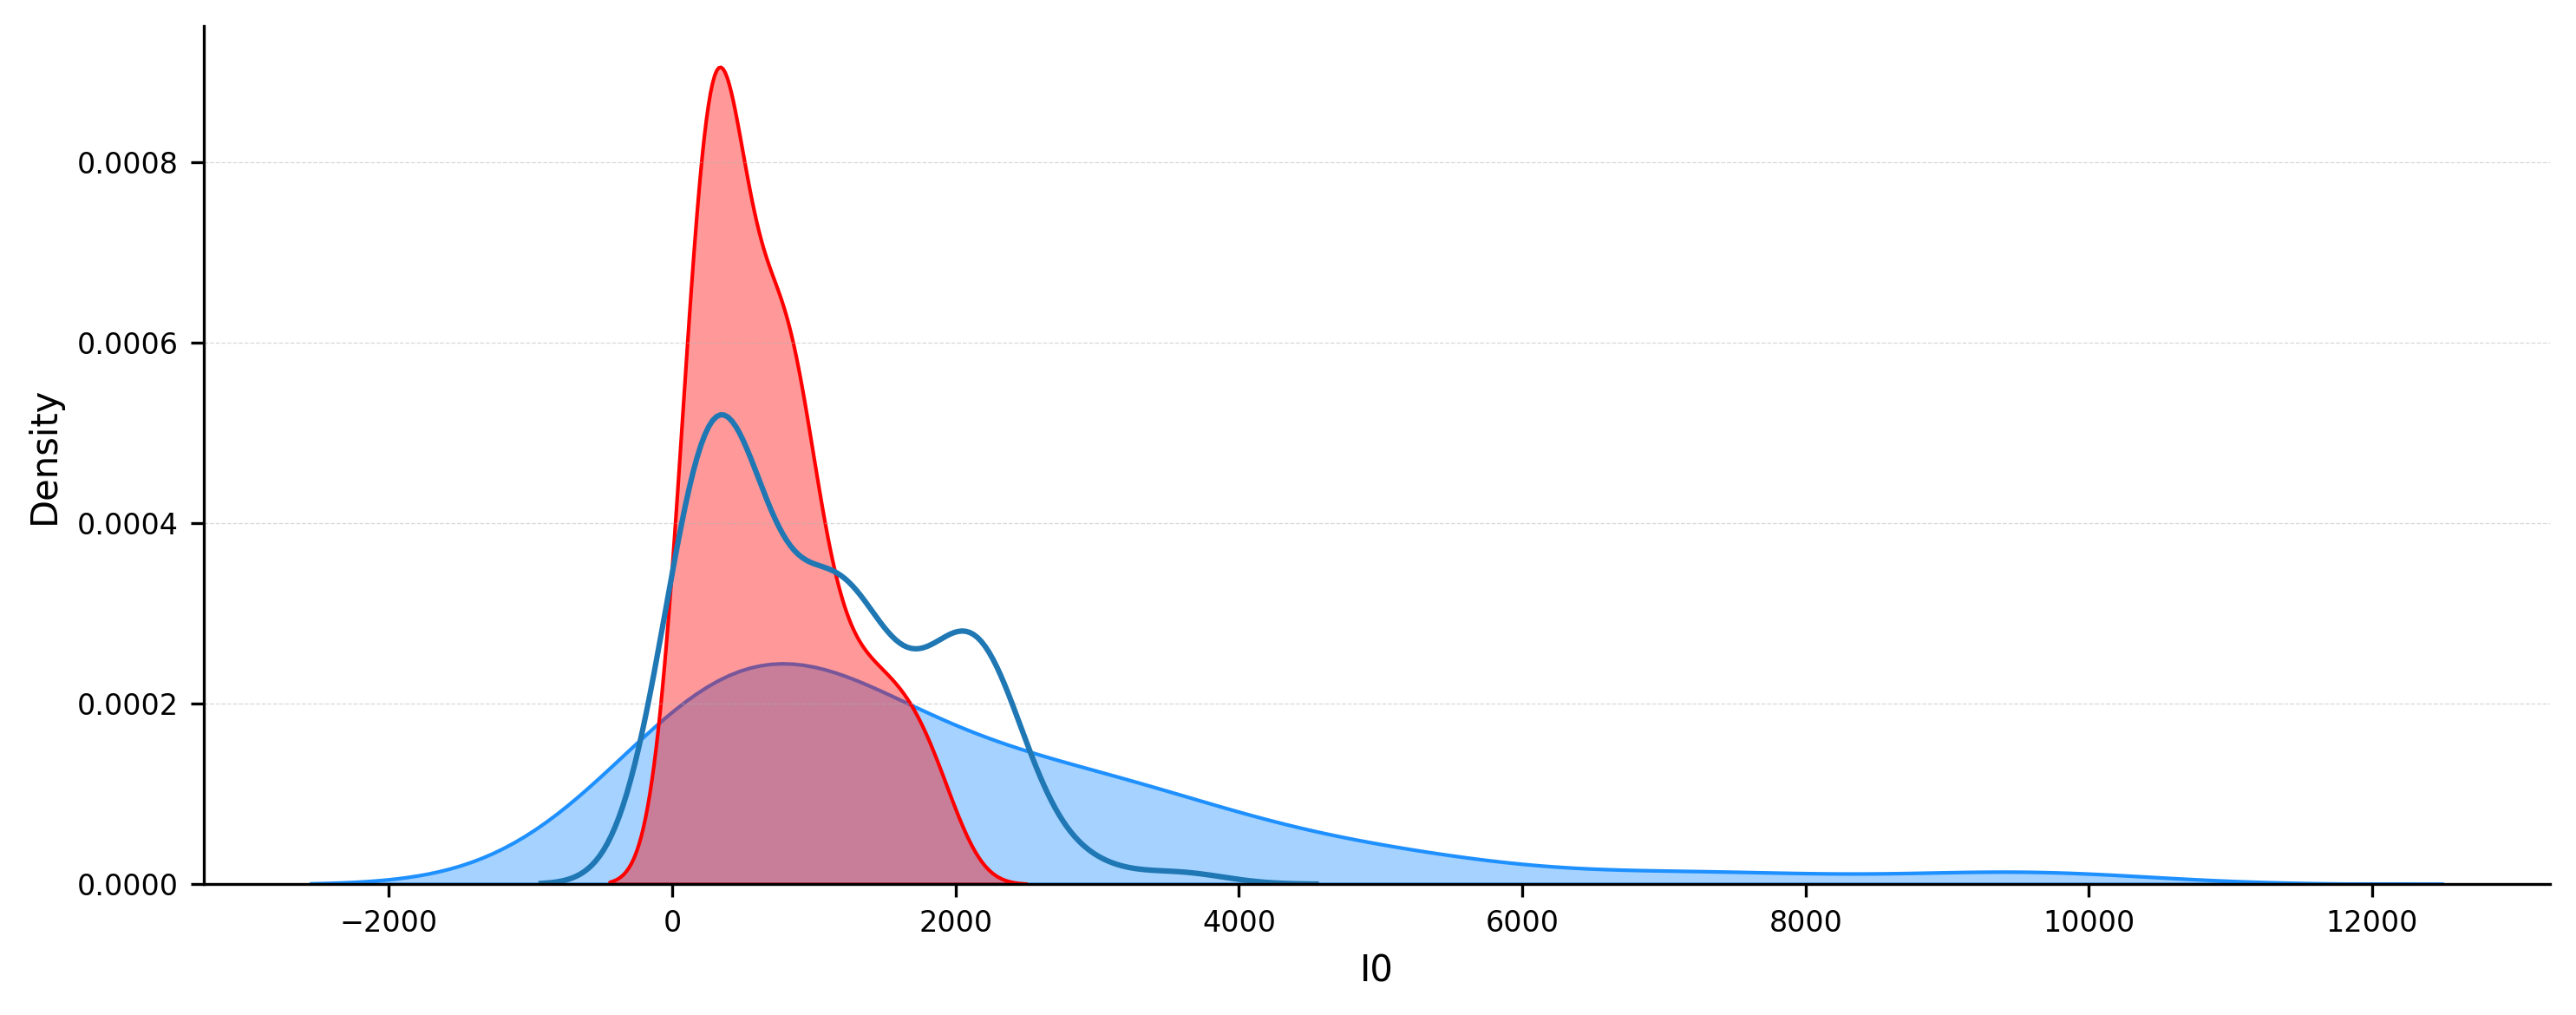

In [115]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "I0", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["I0"], ax=ax)

<Axes: xlabel='Delta', ylabel='Density'>

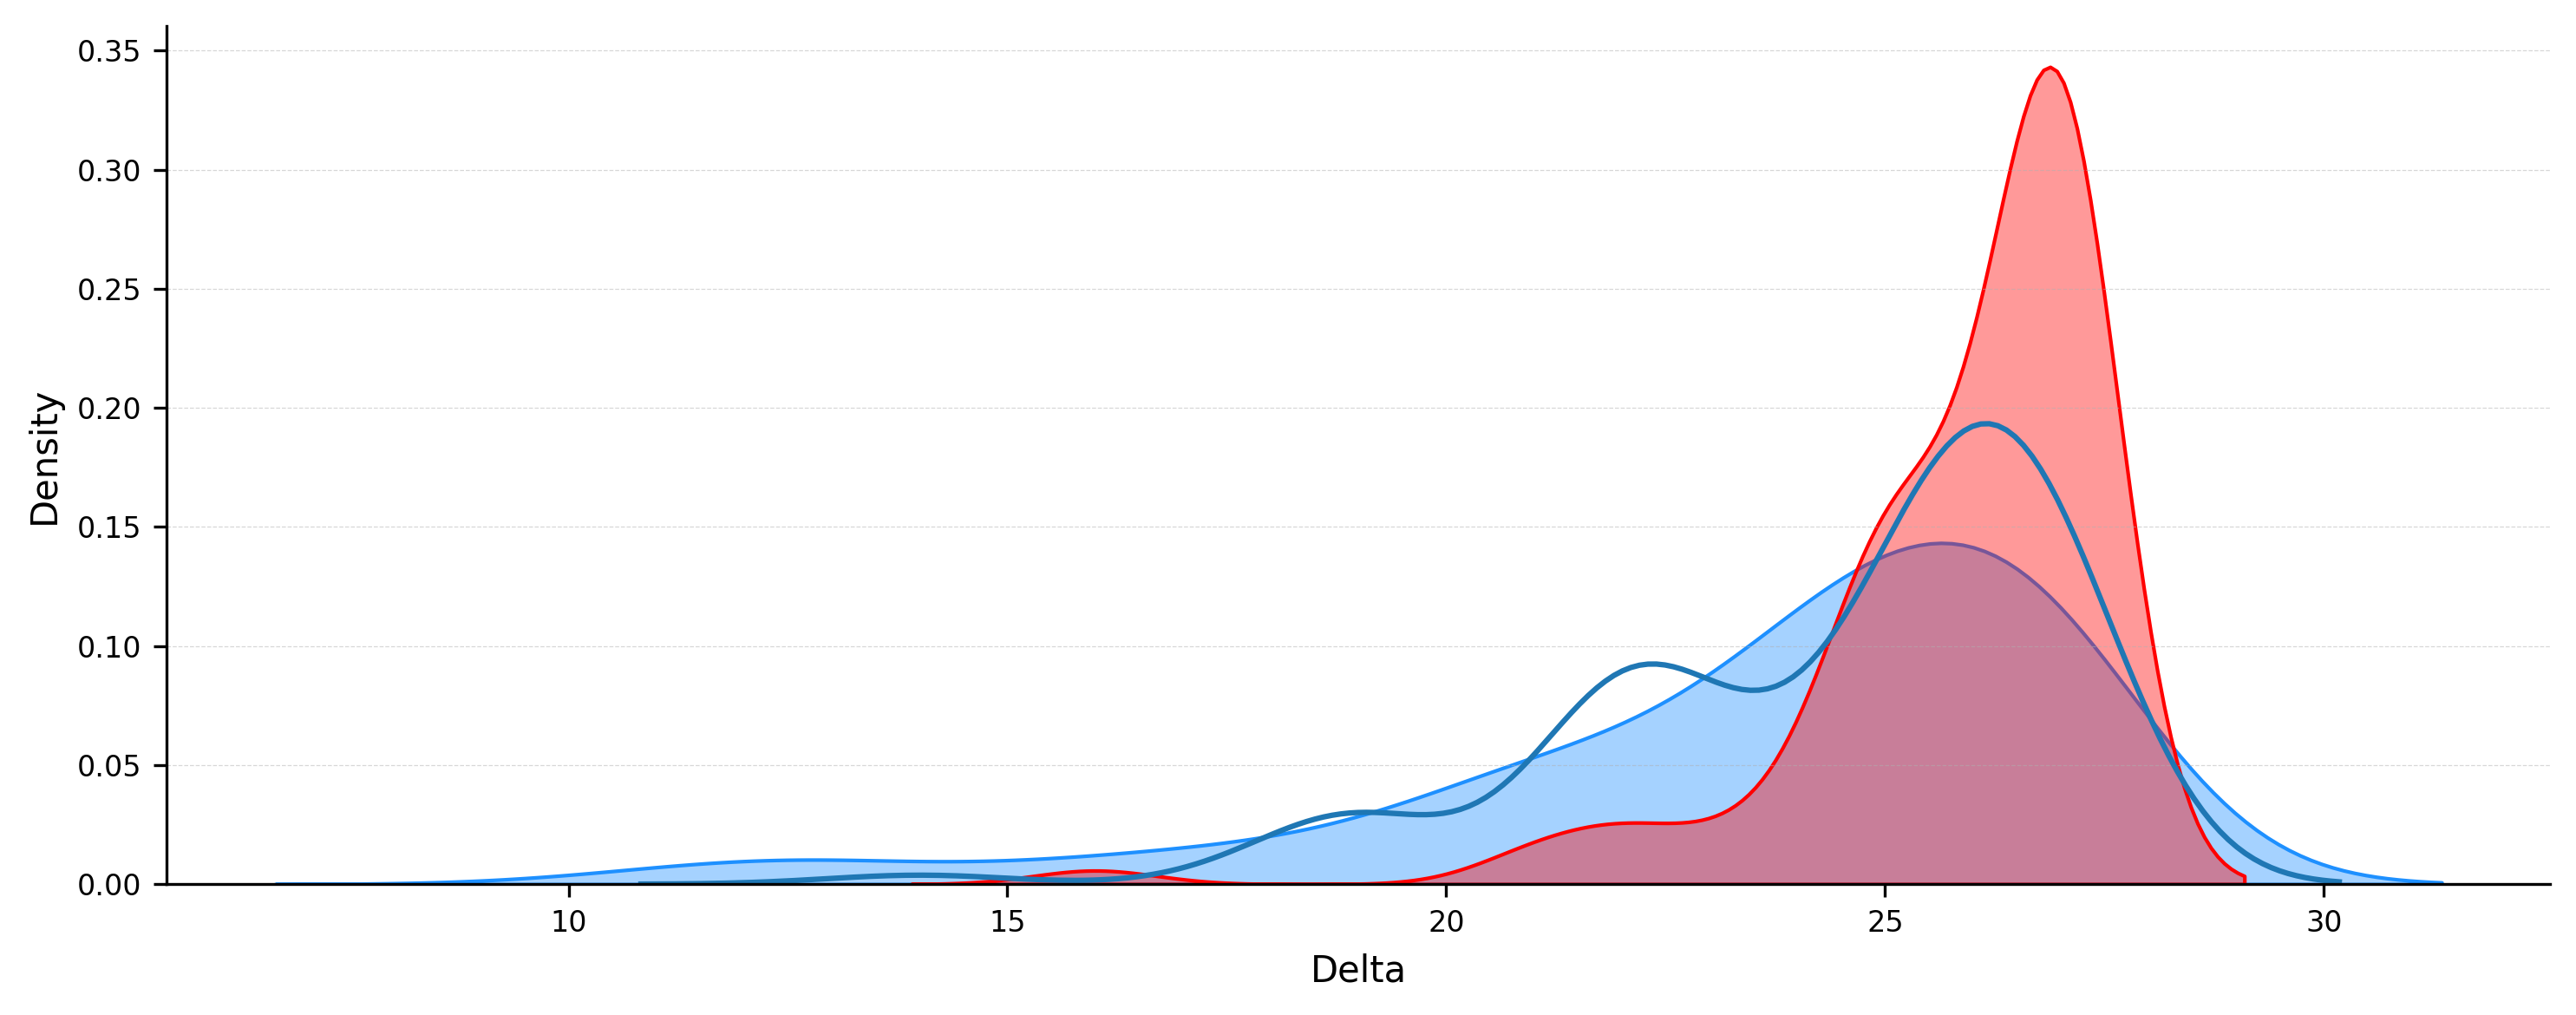

In [116]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "Delta", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "Delta", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["Delta"], ax=ax)

<Axes: xlabel='seasonality_min', ylabel='Density'>

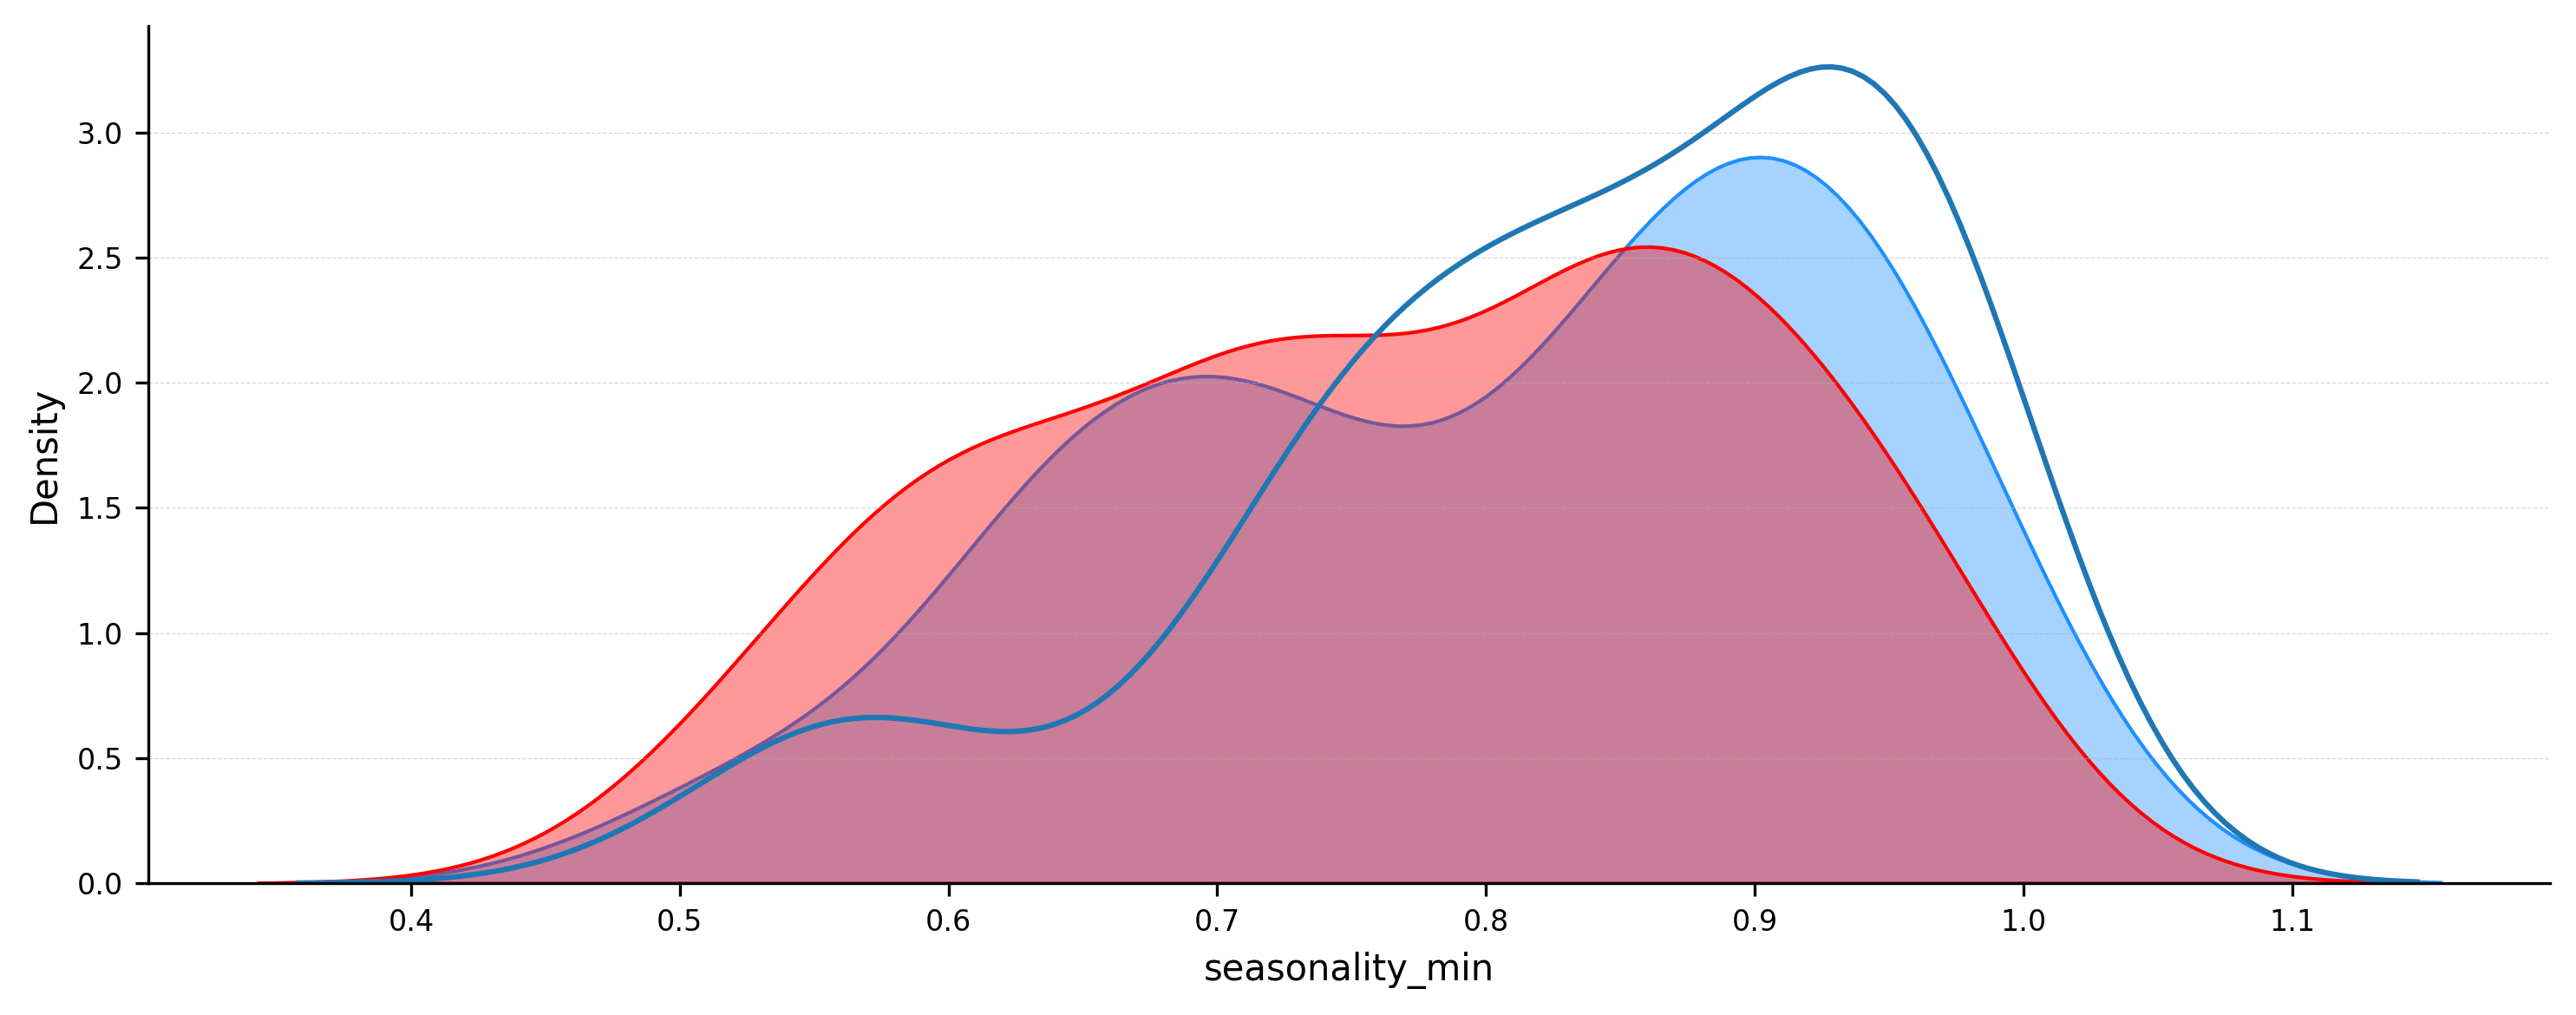

In [117]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "seasonality_min", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "seasonality_min", kind="kde", color="red", ax=ax)
sns.kdeplot(posterior_pyabc["seasonality_min"], ax=ax)

<Axes: xlabel='detection_rate', ylabel='Density'>

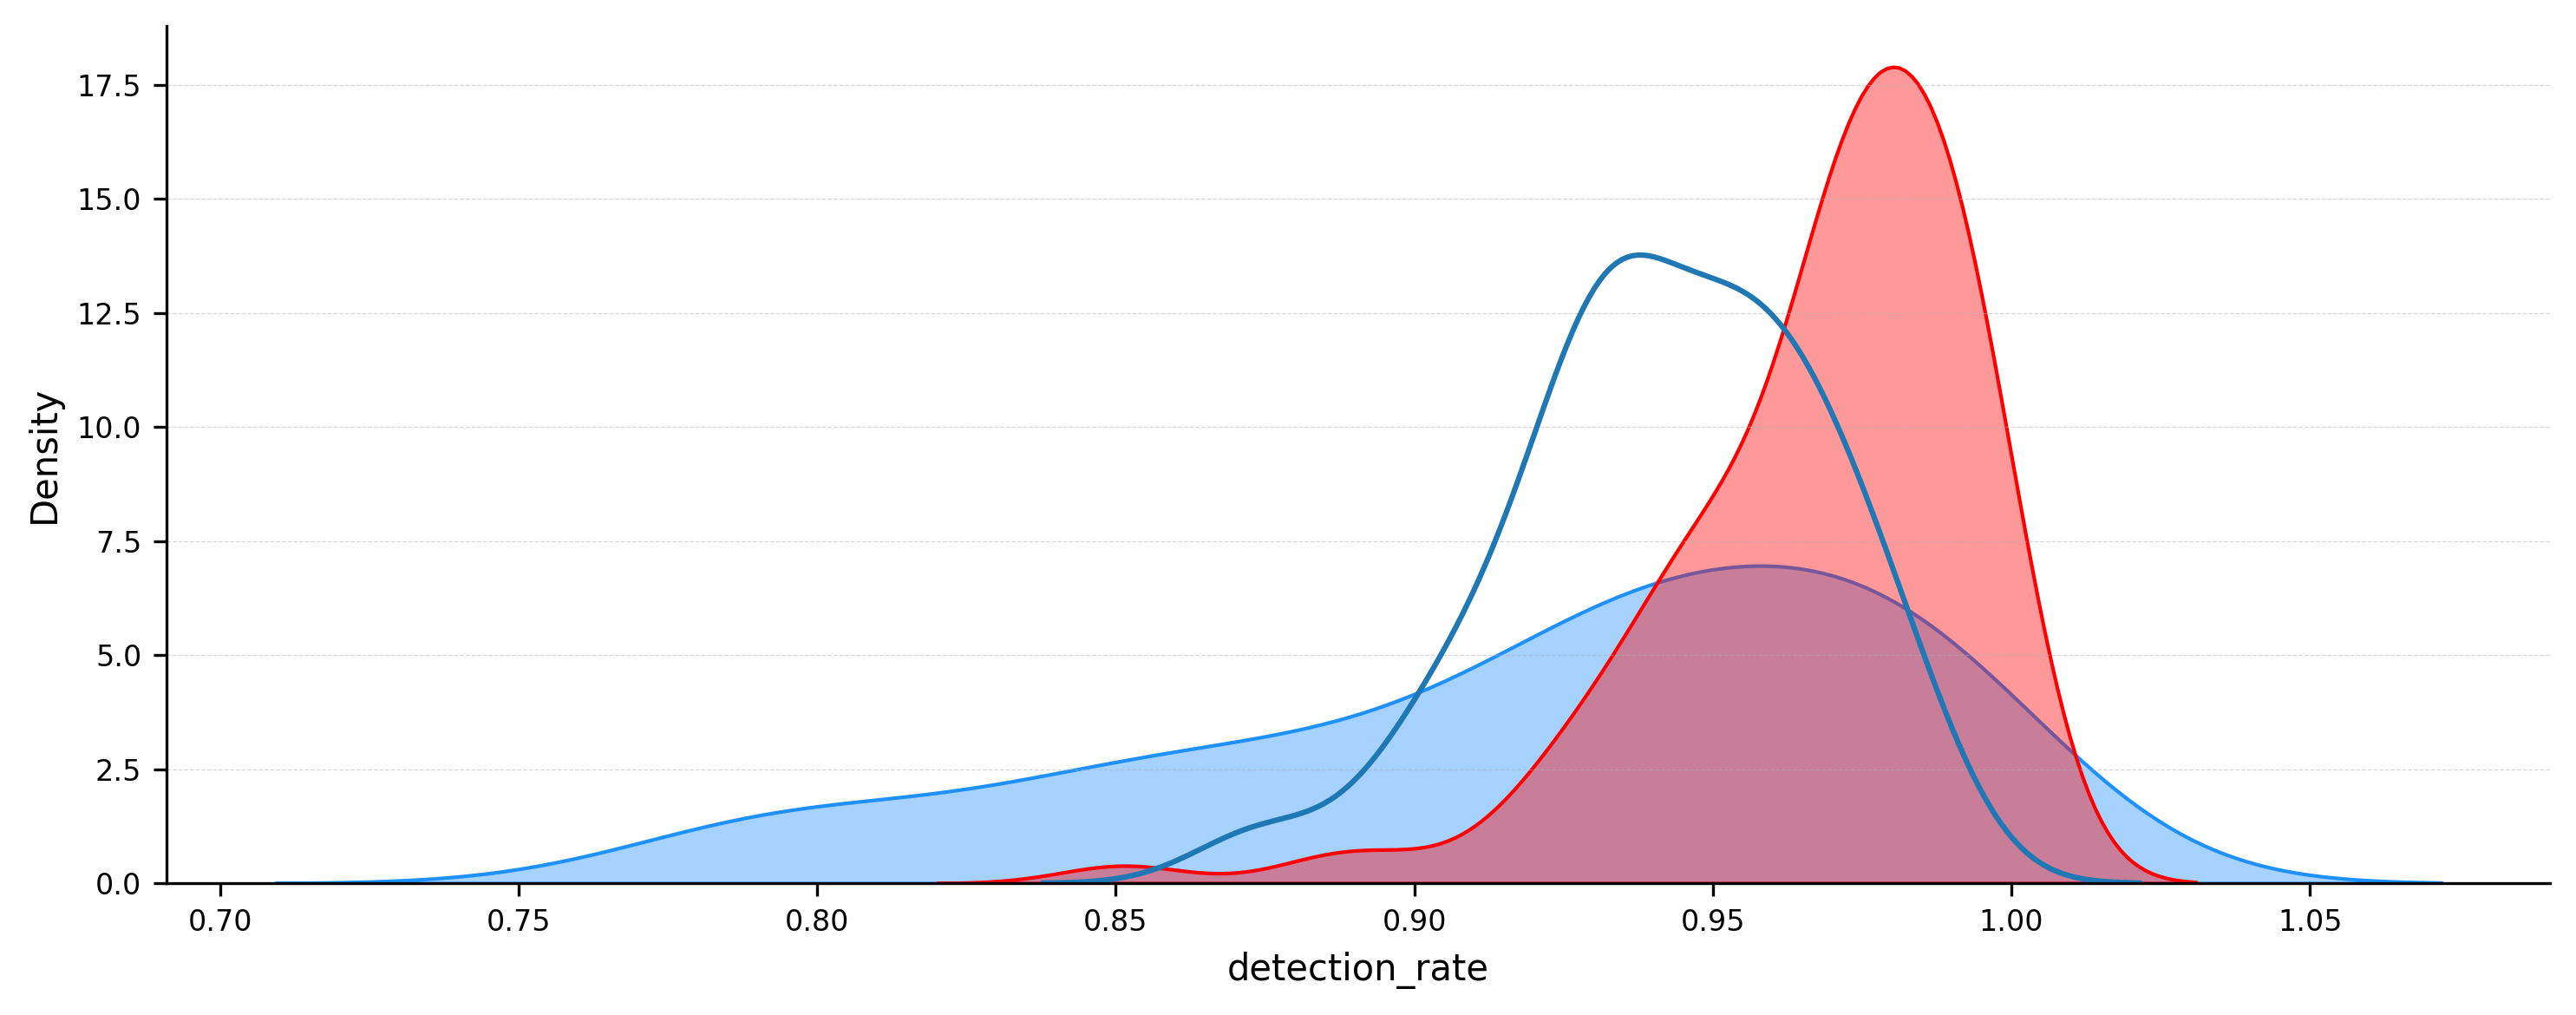

In [118]:
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "detection_rate", kind="kde")
plot_posterior_distribution(results.get_posterior_distribution(), "detection_rate", kind="kde", color="red", ax=ax)

sns.kdeplot(posterior_pyabc["detection_rate"], ax=ax)

<Axes: ylabel='Density'>

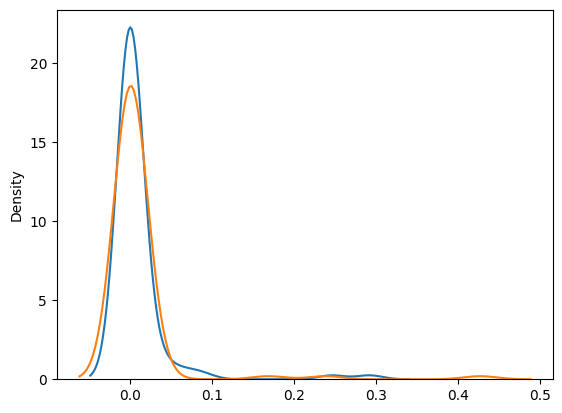

In [119]:
weights_pyabc = history.get_weighted_sum_stats()[0]
weights_epx_rej = results_rejection.get_weights()
weights_epx = results.get_weights()


sns.kdeplot(weights_pyabc, label="PyABC")
sns.kdeplot(weights_epx, label="Epydemix")



In [120]:
print(np.max(weights_epx))
print(np.max(weights_pyabc))

0.42731554277155764
0.2924741556887255


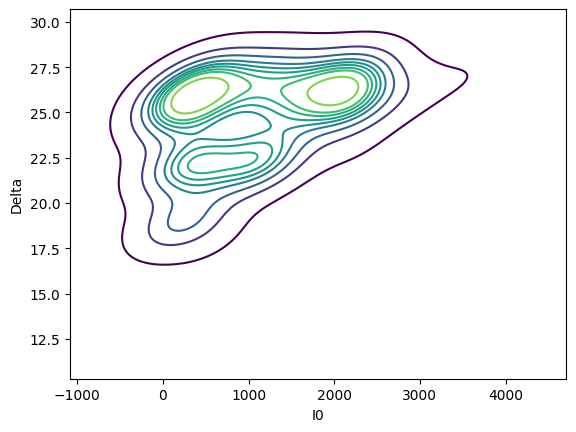

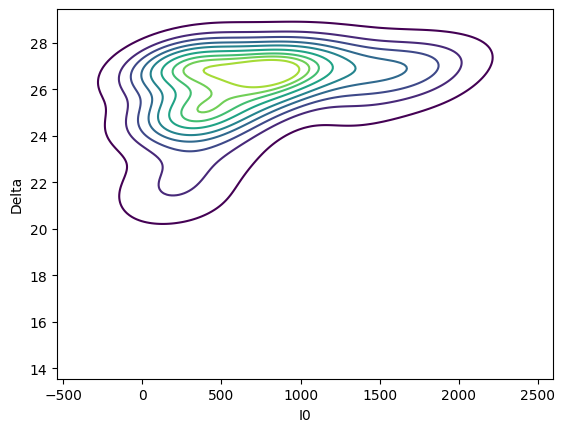

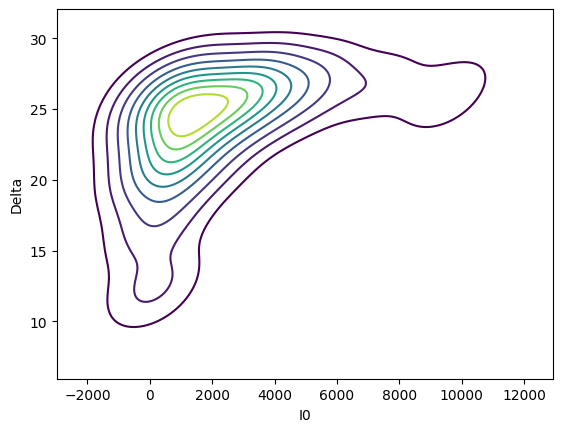

In [121]:

posterior_epx_rej = results_rejection.get_posterior_distribution()
posterior_epx = results.get_posterior_distribution()

sns.kdeplot(data=posterior_pyabc, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx, x="I0", y="Delta", cmap="viridis")
plt.show()
sns.kdeplot(data=posterior_epx_rej, x="I0", y="Delta", cmap="viridis")
plt.show()


In [ ]:
import seaborn as sns
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "R0", kind="kde")
ax = plot_posterior_distribution(results_rejection.get_posterior_distribution(), "I0", kind="kde")


3.597794464438584
3.8123147490347984
4.604553698987807
3.951878099293232
4.170324363694669
4.3050485816657575
4.931590678308979
4.979458001109291


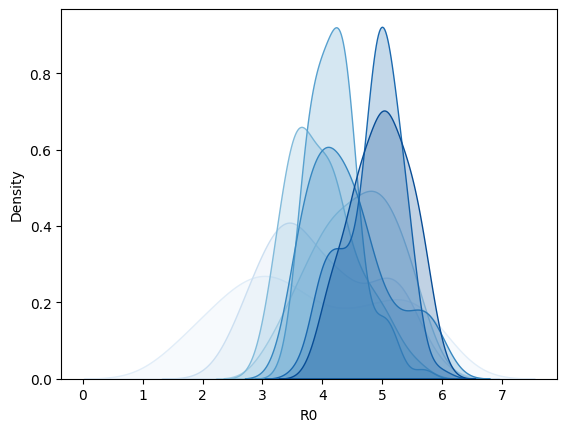

In [34]:
blues = sns.color_palette("Blues", 8)
for i in range(8):
    pr = results.get_posterior_distribution(i)
    sns.kdeplot(pr["R0"], color=blues[i], fill=True)
    print(np.median(pr["R0"]))
